# Imports

In [76]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from scipy import stats
from scipy import optimize
from copy import deepcopy
# import warnings
# warnings.filterwarnings('error')

from multihist import Hist1d, Histdd

# Default settings

In [77]:
# Digitizer sample size
dt = 2
# Pulse time for single pe sampling
dt_fine = 0.2


# Waveform time labels
spe_ts = np.linspace(0, 639*2, 640) - 340 * 2
# Valid time (because the waveform does not range the full time span)
valid_t_range = (-100, 300)
t_mask = (valid_t_range[0] <= spe_ts) & (spe_ts < valid_t_range[1])
spe_ts = spe_ts[t_mask]
spe_t_edges = np.concatenate([[spe_ts[0] - dt/2], spe_ts + dt/2])

spe_ts_fine = np.linspace(*valid_t_range, num = (valid_t_range[1] - valid_t_range[0]) / dt_fine + 1)
spe_ts_fine = spe_ts_fine[:-1]
spe_t_edges_fine = np.concatenate([[spe_ts_fine[0] - dt_fine/2], spe_ts_fine + dt_fine/2])

default_params = dict(
    t1 = 3.1,    # Singlet lifetime, Nest 2014 p2
    t3 = 24,     # Triplet lifetime, Nest 2014 p2
    fs = 0.2,    # Singlet fraction
    tts = 2.,     # Transit time spread.
    f_r = 0.,
    tr = 15,
    fs_r = 0.2,
    
    s1_min=30,
    s1_max=100,
    dset='er',
    # pulse_model=1, # This is the CHANNEL that is used...
    aft = 0.5, # 0.28
    n_photons = int(2e5),
    t_min = -8.,
    t_max = 125.,
    s1_sample = 'data', # 'uniform'
    error_offset  = 0. , 
    error_pct = 0.,
    neglect_statistical = False,
    neglect_systematic = False,
    spe_model = 'template', # expnorm, hybrid?
    s1_model = 'two_exp', # recombination
)

def get_params(params):
    '''
    Returns full set of parameters, setting the values given in `params` and setting the values in 
    `default_params` if not set explicity.
    '''
    for k, v in default_params.items(): # key, value
        params.setdefault(k, v)
    if params['tts'] < 0:
        params['tts'] = 1e-6
    # Parameters that may be smaller than zero
    for par in ['fs', 'aft', 'f_r', 'fs_r']:
        if params[par] < 0:
            params[par] = 0
        elif params[par] >1:
            params[par] =1
    return params

## Load PMT pulses

## Pulse shape

One of the elements of simulted S1s is the single p.e. pulse model. We extract this from the gain calibration dataset.

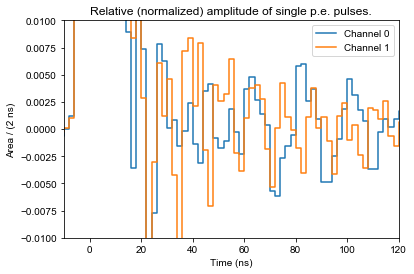

In [78]:
import pickle
from scipy.interpolate import interp1d

spe_pulses_cum = []
spe_ys = []
for ch, fn in enumerate(['170323_103732', '170323_104831']):
    with open('../pulse_shape_single_pe/%s_ch%d.pickle' % (fn, ch) , 'rb') as infile:
        ys = pickle.load(infile)[t_mask]
    plt.plot(spe_ts, ys/ys.sum(), label='Channel %d' % ch, ls='steps')
    spe_ys.append(ys/ys.sum())
    # spe_pulses_cum: list of 2 elements: cumulative distribution for two channels
    spe_pulses_cum.append(
        interp1d(spe_ts, np.cumsum(ys)/ys.sum())
    )
plt.xlabel('Time (ns)')
plt.ylabel('Area / (2 ns)')
plt.legend()
plt.title('Relative (normalized) amplitude of single p.e. pulses.')
plt.xlim(-10, 120)
plt.ylim(-0.01, 0.01)
plt.savefig('plots/pulse_shapes_single.png', bbox_inches='tight', dpi=200)
plt.show()

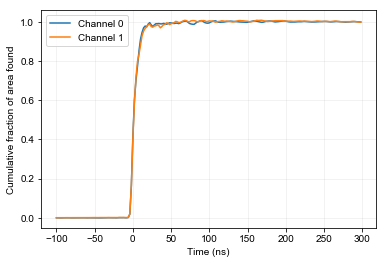

In [79]:
for ch, p in enumerate(spe_pulses_cum):
    plt.plot(spe_ts, p(spe_ts), label='Channel %d' % ch)
plt.grid(alpha=0.2, linestyle='-')
plt.xlabel('Time (ns)')
plt.ylabel('Cumulative fraction of area found')
plt.legend()
plt.show()

What do we need the cumulative fraction for? Well, we input this into the `custom_pmt_pulse_current` in `pax.simulation`. Here is a quick check that all is well. There is just a little shift, but the alignment is quite arbitrary anyway.

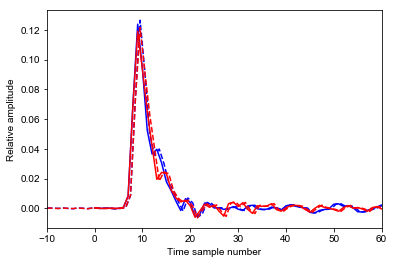

In [80]:
# custom_pmt_pulse_current(pmt_pulse, offset, dt, samples_before, samples_after)
from pax.simulation import custom_pmt_pulse_current
for ch, c in zip([0, 1], ['blue', 'red']):
    plt.plot(custom_pmt_pulse_current(spe_pulses_cum[ch], 0.1, 2, 10, 100), color=c)
    plt.plot(spe_ts * 0.5 + 10 - 0.5, spe_ys[ch] * 0.5, color=c, ls='--')
plt.xlim(-10, 60)
plt.xlabel('Time sample number')
plt.ylabel('Relative amplitude')
plt.show()

### Pulse shape - modified exponential

In [81]:
def exp_mod_gaus(tmin, tmax, tstep, tau, sigma, smearing_sigmas=3,  t0=0):
    '''Give a generous array for t'''
    t = np.arange(tmin, tmax, tstep)
    y_unsmeared = exp(t, tau, t0)
    
    # Maximum number of samples to go left or right
    smear_cutoff = int(np.ceil((smearing_sigmas * sigma) / tstep))
    y_arr = np.array([gaus(i * tstep, sigma) * shift_samples(y_unsmeared, i) for i in range(-smear_cutoff, smear_cutoff)])
#     for y in y_arr:
#         plt.plot(t, y)
    y = np.sum(y_arr, axis=0)
    y = y / np.sum(y) / tstep 
    
    return y
    
def exp(t, tau, t0):
    return (t >= t0) * np.exp(-(t - t0)/(tau))

def gaus(x, sigma):
    return np.exp(-0.5 * (x / sigma)**2)

def shift_samples(y, nsamples):
    '''
    Shift samples to the right (negative means left)
    '''
    if nsamples == 0:
        return y
    elif nsamples > 0:
        return np.concatenate([np.zeros(nsamples), y[:-nsamples]])
    elif nsamples < 0:
        return np.concatenate([y[ - nsamples:], np.zeros(-nsamples)])

def rebin(y, nsamples):
    if len(y) % nsamples != 0:
        raise ValueError('No es possibile')
    nbins = int(len(y) / nsamples)
    return np.average(np.reshape(y, (nbins, nsamples)), axis=1)

In [82]:
def single_pe_model(channel):
    if channel == 0:
        tau, sigma, t0_base = (5.42381418,  0.99909129,  0.60783609)
    elif channel == 1:
        tau, sigma, t0_base = (5.42609904,  0.99867648,  0.86794807)
    y_fine = exp_mod_gaus(tmin = valid_t_range[0], tmax = valid_t_range[1], tau=tau,
                          sigma = sigma, tstep = dt_fine, t0 = t0_base)
    return y_fine

(-1, 20)

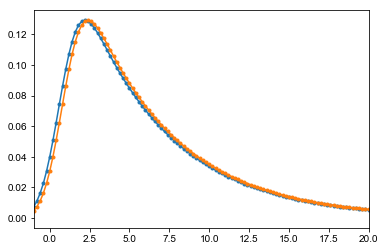

In [83]:
plt.plot(spe_ts_fine, single_pe_model(0), marker = '.')
plt.plot(spe_ts_fine, single_pe_model(1), marker = '.')
plt.xlim(-1, 20)

## Gain variation

In [84]:
gain_params = []
for ch, fn in enumerate(['170323_103732', '170323_104831']):
    with open('../pulse_shape_single_pe/%s_ch%d_function.pickle' % (fn, ch) , 'rb') as infile:
        _norm, _popt, _perr = pickle.load(infile)
        gain_params.append(np.concatenate([np.array([_norm]), _popt, _perr]))
gain_params = np.array(gain_params)

In [85]:
import scipy

def area_sample(n_values, gain_params, channel):
    norm, mu, sigma, _, _ = gain_params[channel]
    lower, upper = (0., 3.)
    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    return X.rvs(n_values)

In [86]:
def gaus_trunc(x, mu, sigma):
    return (x > 0) * np.exp( - (x - mu)**2 / (2 * sigma**2))

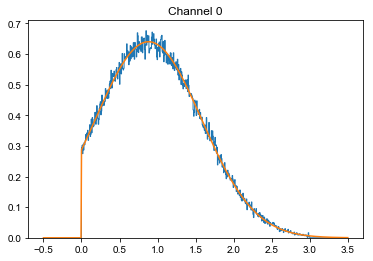

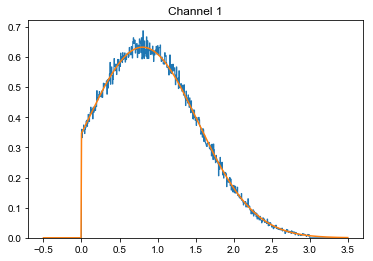

In [87]:
nbins = 600
ran = (-0.5, 3.5)

for channel in (0, 1):
    plt.hist(area_sample(200000, gain_params, channel = channel), bins=nbins, histtype='step', normed=True, range=ran)
    x_plot = np.linspace(*ran, num=nbins)
    y_plot =  gaus_trunc(x_plot,gain_params[channel][1], gain_params[channel][2])
    norm = 1 / (np.sum(y_plot) * (ran[1] - ran[0])) * nbins
    plt.plot(x_plot, norm * y_plot)
    plt.title('Channel %d' % channel)
    plt.show()


# S1 model

## Recombination model

### Earlier model (WRONG AND DEPRICATED)

In [88]:
# import scipy.interpolate

# def cdf_inverse(tau, tr, tmax, nsteps = 100):
#     t = np.linspace(0, tmax, nsteps)
#     return scipy.interpolate.interp1d(cdf_r(t, tau, tr), t, bounds_error=False)

# def cdf_r(t, tau, tr):
#     lambda_s = 1/tau # lambda scintillation
#     lambda_r = 1/tr
#     A = lambda_s * lambda_r / (lambda_s - lambda_r)
#     return A * ((1/lambda_s) * (np.exp(- lambda_s * t) -1) - (1/lambda_r) * (np.exp(- lambda_r * t) -1))

# def simulate_recombination_times(nphotons, tau, tr, tmax, nsteps):
#     cdf_inv_f = cdf_inverse(tau, tr, tmax, nsteps)
#     # Check what the maximum time CDF value is
#     cdf_max = cdf_r(tmax, tau, tr)
#     if (1 - cdf_max) > 0.05:
#         print('Warning: %.2f percent of photons discarted in recombination simulation.' % ((1 - cdf_max) * 100))
#     times = cdf_inv_f(np.random.rand(nphotons) * cdf_max)
#     return times

In [89]:
# def Ir(t, tau, tr):
#     lambda_s = 1/tau # lambda scintillation
#     lambda_r = 1/tr
#     n0 = 1
#     return n0 * lambda_r * lambda_s / (lambda_s - lambda_r) * (np.exp(- lambda_r * t) - np.exp(- lambda_s * t))

In [90]:
# %%time
# times = simulate_recombination_times(2e5, 3, 15, 200, 200)

In [91]:
# t_plot = np.linspace(0, 200, 200)

# plt.hist(times, bins=500, range=(0, 200), histtype='step', normed=True, label='Simulated values')
# plt.plot(t_plot, Ir(t_plot, 3, 15), label='PDF')
# plt.plot(t_plot, Ir(t_plot, 25, 15), label='PDF')

# plt.legend()
# plt.show()

### Good model (good and not depricated)

In [92]:
import scipy.integrate as integrate


def n(t, tr):
    """
    Density of ions and electrons supposing hot electron escape prob. of zero and uniform density
    """
    return 1 / (1 + t/tr)

def Ir2(t, tau, tr):
    '''The intensity of scintillation, AKA the PDF distibution for photons!'''
    if isinstance(t, float) or isinstance(t, int):
        return np.exp(-t/tau) / tau * integrate.quad(lambda x: n(x, tr)**2 * np.exp(x/tau), 0, t)[0]
    else:
        return np.array([Ir2(_t, tau, tr) for _t in t])

def Ir2_cdf(t, tau, tr):
    pdf = Ir2(t, tau, tr)
    return np.cumsum(pdf) / sum(pdf)

def Ir2_cdf_inv(t, tau, tr):
    cdf = Ir2_cdf(t, tau, tr)
    return scipy.interpolate.interp1d(cdf, t)

def simulate_recombination_times(nphotons, tau, tr, tmax, nsteps):
    t = np.linspace(0, tmax, nsteps)
    return Ir2_cdf_inv(t, tau, tr)(np.random.rand(nphotons))

Demonstration

In [93]:
tr = 15
tau = 22

In [94]:
%%time
mc_sample = simulate_recombination_times(2e5, tau, tr, tmax=250, nsteps = 500)

CPU times: user 72 ms, sys: 0 ns, total: 72 ms
Wall time: 73 ms


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


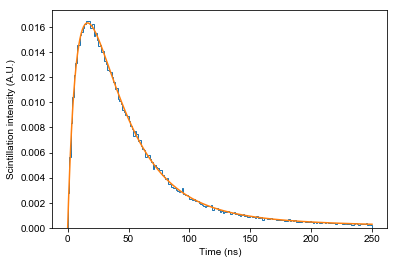

In [95]:
plt.hist(mc_sample, bins=200, normed=True, histtype='step')
x_plot = np.linspace(0, 250, 500)
pdf = Ir2(x_plot, tau, tr)
pdf= pdf / np.sum(pdf) * 2 # 2 from 1 / step size
plt.plot(x_plot, pdf)
plt.xlabel('Time (ns)')
plt.ylabel('Scintillation intensity (A.U.)')
plt.show()

## Simulation

In [96]:
import numba

def split_s1_groups(x, n_x, areas, channels, **params):
    """Splits x into groups with uniform (s1_min, s1_max) elements, then return matrix of histograms per group.
    Returns: integer array (n_x, n_groups)
    n_x: number of possible values in x. Assumed to be from 0 ... n_x - 1
    s1_min: minimum S1 number of hits
    s1_max: maximum S1 number of hits
    """
    params = get_params(params)
    # We want to exhaust the indices x. Simulate a generous amount of S1 sizes
    n_s1_est = int(1.5 * 2 * len(x) / (params['s1_min'] + params['s1_max']))
    
    if params['s1_sample'] == 'data' and 'xams_data' not in globals():
        print('Warning: data-derived s1 area distribution not possible, reverting to uniform...')
        params['s1_sample'] = 'uniform'
    if params['s1_sample'] == 'uniform':
        pe_per_s1 = (params['s1_max'] - params['s1_min']) * np.random.random(size=n_s1_est) + params['s1_min']
    elif params['s1_sample'] == 'data':
        # Take S1 from the data sample
        s1s_data = xams_data[params['dset']]['s1']
        s1s_data = s1s_data[(s1s_data >= params['s1_min']) & (s1s_data < params['s1_max'])]
        pe_per_s1  = np.random.choice(s1s_data, size=n_s1_est)
    else:
        raise ValueError('Configuration not understood, got this: ', params['s1_sample'])
    # These are two arrays for the two channels
    # i.e. these will later yield the top and bottom waveform
    result0 = np.zeros((n_x, n_s1_est), dtype=float)
    result1 = np.zeros((n_x, n_s1_est), dtype=float)
    s1_i = _split_s1_groups(x, pe_per_s1, result0, result1, areas, channels)
    return result0[:,:s1_i - 1], result1[:,:s1_i - 1]


@numba.jit(nopython=True)
def _split_s1_groups(x, pe_per_s1, result0, result1, areas, channels):
    # One of these days, I'm going to cut you into little pieces
    s1_i = 0
    for photon_i, (i, ch) in enumerate(zip(x, channels)):
        if pe_per_s1[s1_i] < 0:
            s1_i += 1
            continue
        if ch == 0:
            result0[i, s1_i] += areas[photon_i]
        if ch == 1:
            result1[i, s1_i] += areas[photon_i]
        pe_per_s1[s1_i] -= areas[photon_i]
    return s1_i 

# %%timeit
# split_s1_groups(np.random.randint(0, 100, size=int(1e6)), 101, 10, 20)

def shift(x, n):
    """Shift the array x n samples to the right, adding zeros to the left."""
    if n > 0:
        return np.pad(x, (n, 0), mode='constant')[:len(x)]
    else:
        return np.pad(x, (0, -n), mode='constant')[-len(x):]



def simulate_s1_pulse(**params):
    # n_photons=int(2e5), 
    """Return (wv_matrix, time_matrix, t_shift vector) for simulated S1s, consisting of n_photons in total
    """
    params = get_params(params)
    n_photons = params['n_photons']

    ##
    # Make matrix (n_samples, n_waveforms) of pulse waveforms with various shifts
    ##
    wv_matrix_list = []
    for ch in [0, 1]:
        # This is a matrix filled with waveforms, ordered by their SHIFT.
        # So, these are all just model waveforms and will be selected later
        if params['spe_model'] == 'template':
            y = spe_ys[ch]  # This is the CHANNEL
            i_noshift = np.searchsorted(spe_t_edges, [0])[0]    # Index corresponding to no shift in the waveform
            wv_matrix = np.vstack([shift(y, i - i_noshift) 
                               for i in range(len(spe_ts))]).T 
        elif params['spe_model'] == 'expnorm':            
            y = single_pe_model(ch)
            i_noshift = np.searchsorted(spe_t_edges_fine, [0])[0]    # Index corresponding to no shift in the waveform
            wv_matrix = np.vstack([rebin(shift_samples(y, i - i_noshift), int(dt / dt_fine))
                               for i in range(len(spe_ts_fine))]).T 
        else:
            raise ValueError('spe model not understood')
        wv_matrix_list.append(wv_matrix)
    
    ##
    # Simulate S1 pulse times, convert to index
    ##

    # Channel selector
    n_top = np.random.binomial(n=n_photons, p=params['aft']) # Number of photons happening in top array
    # First all the top channels, then all the bottom channels (ch1)
    channels = np.concatenate([np.zeros(n_top, dtype=int), np.ones(n_photons - n_top, dtype=int)])
    areas = np.concatenate([area_sample(n_top, gain_params, channel=0), 
                            area_sample(n_photons - n_top, gain_params, channel=1)])
    # Shuffle the two lists the exact same way
    channels, areas = unison_shuffled_copies(channels, areas)
    
    # Time is distributed according to exponential distribution
    # This is the TRUE time of all the photons generated, assuming time=0  is the time of the interaction
    times = np.zeros(n_photons)

    if params['s1_model'] == 'two_exp':
        n_singlets = np.random.binomial(n=n_photons, p=params['fs']) # We randomly select if the photon came from a 
                                                                     # singlet or triplet decay
        times += np.concatenate([
            np.random.exponential(params['t1'], n_singlets),
            np.random.exponential(params['t3'], n_photons - n_singlets)
        ])
    elif params['s1_model'] == 'recombination':
        n_recombination = np.random.binomial(n=n_photons, p=params['f_r'])
        n_recombination_singlets = np.random.binomial(n=n_recombination, p=params['fs_r'])
        n_recombination_triplets = n_recombination - n_recombination_singlets
        n_direct = n_photons - n_recombination
        n_direct_singlets = np.random.binomial(n=n_direct, p=params['fs'])
        n_direct_triplets = n_direct - n_direct_singlets
        assert (n_recombination_singlets + n_recombination_triplets + n_direct_singlets + n_direct_triplets == n_photons)        
        times += np.concatenate([
            np.random.exponential(params['t1'], n_direct_singlets),
            np.random.exponential(params['t3'], n_direct_triplets),
            simulate_recombination_times(n_recombination_singlets, params['t1'], params['tr'], 250, 500), 
            simulate_recombination_times(n_recombination_triplets, params['t3'], params['tr'], 250, 500), 
        ])
    else:
        raise ValueError('S1 model type not understood, got this: %s' % params['s1_model'])
        
        
        
    # Since `times` is now sorted in (singlet, triplet), shuffle them
    np.random.shuffle(times)
    
    # Here we start taking into account detector physics: the transit time spread (simulated as normal dist.)
    times += np.random.normal(0, params['tts'], size=n_photons)
    
    # Find the bin that the photon would be in if it were sampled.
    # Now, we delete all the photons that are outside of the bin range and re-match to the bin centers
    # (Check the searchsorted documentation)
    if params['spe_model'] == 'template':
        indices = np.searchsorted(spe_t_edges, times)
        indices = indices[~((indices == 0) | (indices == len(spe_t_edges)))] - 1
    elif params['spe_model'] == 'expnorm':
        indices = np.searchsorted(spe_t_edges_fine, times)
        indices = indices[~((indices == 0) | (indices == len(spe_t_edges_fine)))] - 1



    # This is the new amount of photons simulated
    if len(indices) < n_photons:
        # print('Warning: I just threw away %d photons...' % (n_photons - len(indices)))
        n_photons = len(indices)
    
    ##
    # Build instruction matrix, simulate waveforms
    ##
    # So far, we've just been simulating a bunch of photons (very many).
    # We are now going to split this into S1s: the split will be made at a random point between s1_min and s1_max.
    # `index_matrix` is a matrix split into groups forming S1s. 
    # We've got two for the two channels    
    if params['spe_model'] == 'template':
        index_matrix0, index_matrix1 = split_s1_groups(indices, len(spe_t_edges) - 1, areas,channels, **params)
    elif params['spe_model'] == 'expnorm':
        index_matrix0, index_matrix1 = split_s1_groups(indices, len(spe_t_edges_fine) - 1, areas,channels, **params)

    # Now, index_matrix[:, 0] contains a list of number of entries for the shift for each timestamp in bin
    n_s1 = index_matrix0.shape[1]
    
    # Remember that wv_matrix is a matrix of waveforms, each element at position i of which is shifted i samples
    s1_waveforms = np.dot(wv_matrix_list[0], index_matrix0) + np.dot(wv_matrix_list[1], index_matrix1)
    # return s1_waveforms

    ##
    # Alignment based on maximum sample, compute average pulse
    ##
    time_matrix, t_shift = aligned_time_matrix(spe_ts, s1_waveforms)    
    return s1_waveforms, time_matrix, t_shift

def aligned_time_matrix(ts, wv_matrix, mode = '10p'):
    """Return time matrix that would align waveforms im wv_matrix"""
    n_s1 = wv_matrix.shape[1]

    if mode == 'max':
        # Find the position of maximum sample and match its times
        t_shift = ts[np.argmax(wv_matrix, axis=0)]
    elif mode == '10p':
        fraction_reached = np.cumsum(wv_matrix, axis=0) / np.sum(wv_matrix, axis=0)
        # Get the sample where 10% is reached by taking the sample closest to the 10% point
        # This is as good as you can get without introducing fractional samples (which may be an improvement)
        # TODO get interpolation in here
        distance_to_10p_point = np.abs(fraction_reached - 0.1)
        t_shift = ts[np.argmin(distance_to_10p_point, axis=0)]
    
    time_matrix = np.repeat(ts, n_s1).reshape(wv_matrix.shape)
    time_matrix -= t_shift[np.newaxis,:]
    return time_matrix, t_shift

def average_pulse(time_matrix, wv_matrix):
    """Return average pulse, given time and waveform matrices"""
    h, _ = np.histogram(time_matrix, bins=spe_t_edges, weights=wv_matrix)
    h /= h.sum()
    return h

def s1_average_pulse_model(*args, **kwargs):
    wv_matrix, time_matrix, _ = simulate_s1_pulse(*args, **kwargs)
    return average_pulse(time_matrix, wv_matrix)

def unison_shuffled_copies(a, b):
    '''Stack overflow to the rescue'''
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

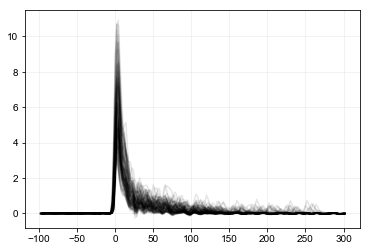

In [97]:
s1_wvs, tmat, _ = simulate_s1_pulse(n_photons=int(2e5), t3=1, t1=50, tts=1, fs=0.5, dset='nr')
for i in range(100):
    plt.plot(tmat[:, i], s1_wvs[:, i], alpha=0.1, c='k')
plt.grid(alpha=0.2, linestyle='-')

Here is what we get out.
`wv_matrix` is a matrix containing the y-coordinates of the waveforms. The columns are the individual waveforms, to get the first waveform, go `wv_matrix[:, 0]`. `time_matrix` is the same thing except for it contains the times. `t_shift_vector` contains the shift of the waveform in ns (based on pulse times).

## Statistical errors

Here we simulate statistical errors by simulating `n_data_s1s` and then performing bootstrap trials. The conclusion:....

The errors are small but still interesting. We perform the bootstrapping on DATA instead, see later on...

In [98]:
def s1_models_resample(*args, n_data_s1s=1000, bootstrap_trials=10, **kwargs):
    """Return bootstrap_trials waveform templates from sampling n_data_s1s s1s"""
    wv_matrix, time_matrix, _ = simulate_s1_pulse(*args, **kwargs)
    n_s1s = wv_matrix.shape[1]
    
    waveform_templates = np.zeros((len(spe_ts), bootstrap_trials))

    for i in range(bootstrap_trials):
        new_indices = np.random.randint(n_s1s, size=n_data_s1s)

        waveform_templates[:, i] = average_pulse(time_matrix[:, new_indices], 
                                                 wv_matrix[:, new_indices])
    
    return waveform_templates

def sigmas_plot(x, q, color='b', **kwargs):
    for n_sigma, alpha in [(1,0.5), (2, 0.1)]:
        plt.fill_between(x,
                         np.percentile(q, 100 * stats.norm.cdf(-n_sigma), axis=1),
                         np.percentile(q, 100 * stats.norm.cdf(n_sigma), axis=1),
                         alpha=alpha, linewidth=0, color=color, step='mid')
    plt.plot(x, 
             np.percentile(q, 50, axis=1), 
             color=color, linestyle='-', alpha=0.5, linewidth=1, **kwargs)

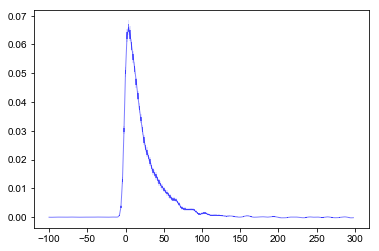

In [99]:
waveform_templates = s1_models_resample(n_data_s1s=100, s1_min=50, s1_max=60, bootstrap_trials=100)
sigmas_plot(spe_ts, waveform_templates)

## Systematic errors

In [100]:
import itertools
import math
def s1_models_error(*args, shifts=None, mode='std', **kwargs):
    '''
    Compute the error on the S1 waveform given errors on specific parameters.
    This will compute the S1 model for parameter +error, +0, and -error.
    All combinations of parameters are tried.
    `shifts` is a dict containting the allowed shift (+/-) for each model parameter.
    `*args` and `**kwargs` will be passed to `s1_average_pulse_model` to compute the base model.
    This function can also be used for getting the difference in pulse model for channel 0 and 1.
    '''
    if kwargs.get('neglect_systematic', default_params['neglect_systematic']):
        base_model = s1_average_pulse_model(*args, **kwargs)
        return base_model, base_model, base_model
    
    
    if shifts is None:
        # Default uncertainty: in pulse model and in TTS
        shifts = dict(tts=0.5, aft=0.5)
    
    # Allow specifying a single +- amplitude of variation
    for p, shift_values in shifts.items():
        if isinstance(shift_values, (float, int)):
            shifts[p] = kwargs.get(p, default_params[p]) + np.array([-1, 0, 1]) * shift_values
    

    shift_pars = sorted(shifts.keys())
    shift_values = [shifts[k] for k in shift_pars]
    # shift_value_combs is a list of paramters that will be tried to compute the average pulse.
    # Contains all combintations: (+, 0, -) for all the parameters. ((3n)^2 for n number of parameters.)
    shift_value_combs = list(itertools.product(*shift_values))
    noshift_comb = tuple([(kwargs.get(p, default_params[p])) for p, shift_values in shifts.items()])
    noshift_index = int((len(shift_value_combs) -1) /2)
    # Check if we have the right index
    
    for i, comb in enumerate(shift_value_combs):
        if np.all([np.isclose(a,b) for a, b in zip(comb, noshift_comb)]):
            noshift_index = i
        
        
    # for a, b in zip(noshift_comb, shift_value_combs[noshift_index]):
        
    
    alt_models = []
    for vs in shift_value_combs:
        kw = dict()
        kw.update(kwargs)
        for i, p in enumerate(shift_pars):
            kw[p] = vs[i]        
        alt_models.append(s1_average_pulse_model(*args, **kw))
    
    
    alt_models = np.vstack(alt_models)
    base_model = alt_models[noshift_index]
    # Hmmm. this seems like an upper estimate of the error, no?
    # ask jelle
    # return alt_models
    if mode == 'extreme':
        minus = np.min(alt_models, axis=0)
        plus = np.max(alt_models, axis=0)
    elif mode == 'std':
        sigma_sys = np.std(alt_models, axis=0)
        minus = base_model - sigma_sys
        plus = base_model + sigma_sys
    else:
        raise ValueError('Mode %s not known' % mode)
    
    return minus, base_model, plus
    

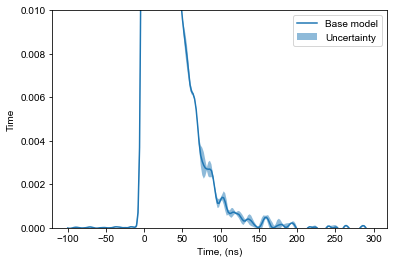

In [101]:
minus, base, plus = s1_models_error(mode='std')
plt.fill_between(spe_ts, minus, plus, alpha=0.5, linewidth=0, label='Uncertainty')
plt.plot(spe_ts, base, label='Base model')
plt.xlabel('Time, (ns)')
plt.ylabel('Time')
plt.legend()
plt.ylim(0, 0.01)
plt.show()


# Real data waveforms

## Read the data

Here we read the S1 data for three (highfield) datasets: NR, ER and BG_NR. We store it in the form of a dict (keys: er, nr, bg_nr). Each dict item is an array containing the waveforms (per row).

In [102]:
xams_data = dict()
xams_data['nr'], xams_data['er'], xams_data['bg_nr'] = pickle.load(open('highfield_dataframes.pickle', 'rb'))
xams_data['er_0'] = pickle.load(open('zerofield_dataframes_temp.pickle', 'rb'))
xams_data['nr_l'], xams_data['er_l'] = pickle.load(open('lowfield_dataframes.pickle', 'rb'))
xams_s1s = dict()
# Get pulse waveforms to matrix rather than object column
for k, d in xams_data.items():
    xams_s1s[k] = np.array([x for x in d['s1_pulse']])
    del d['s1_pulse']

Here's an example waveform

## AFT

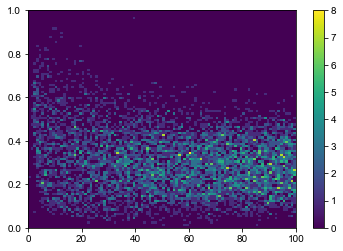

In [103]:
dset = 'er'
plt.hist2d(xams_data[dset]['s1'], xams_data[dset]['s1_area_fraction_top'], bins=100, range=((0, 100), (0, 1)))
plt.colorbar()
plt.show()

Dataset er: aft = 0.291 +- 0.119
Dataset nr: aft = 0.267 +- 0.127


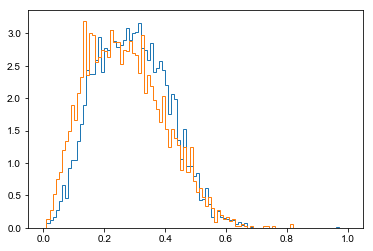

In [104]:
for dset in ['er', 'nr']:
    sel = (xams_data[dset]['s1'] >= 30) & (xams_data[dset]['s1'] < 100)
    afts = xams_data[dset]['s1_area_fraction_top'][sel]
    plt.hist(afts, bins=100, histtype='step', normed=True, label=dset, range=(0,1))
    print('Dataset %s: aft = %.3f +- %.3f' % (dset, np.average(afts), np.std(afts)))
plt.show()

For now use 0.28 +- 0.12 as uncertainty of the fit

## Alignment, averaging, bootstrapping

In [105]:
def real_s1_wv(**params):
    """Return average S1 waveform, number of S1s it was constructed from"""
    params = get_params(params)
    
    areas = xams_data[params['dset']]['s1'].values
    mask = (params['s1_min'] < areas) & (areas < params['s1_max'])

    # Could now derive distribution, I'll just assume uniform for the moment.
    # Hist1d(areas[mask],
    #        bins=np.linspace(params['s1_min'], params['s1_max'], 100)).plot()

    n_data_s1s = mask.sum()
    wvs = xams_s1s[params['dset']][mask].T
    tmat, _ = aligned_time_matrix(spe_ts, wvs)
    real_s1_avg =  average_pulse(tmat, wvs)
    
    return real_s1_avg, n_data_s1s

In [106]:
def real_s1_wv_sigma(bootstrap_trials = 25, **params):
    """Take data S1s, bootstrap sample, then check what the variance is"""
    params = get_params(params)
    
    time_matrix, wv_matrix = real_s1_wv_matrix(**params)
    n_s1s = wv_matrix.shape[1]
    waveform_templates = np.zeros((len(spe_ts), bootstrap_trials))

    for i in range(bootstrap_trials):
        new_indices = np.random.randint(n_s1s, size=n_s1s)

        waveform_templates[:, i] = average_pulse(time_matrix[:, new_indices], 
                                                 wv_matrix[:, new_indices])
        
    
    return np.std(waveform_templates, axis=1)

In [107]:
def real_s1_wv_matrix(**params):
    """Return the aligned time matrix and waveform matrix."""
    params = get_params(params)
    
    areas = xams_data[params['dset']]['s1'].values
    mask = (params['s1_min'] < areas) & (areas < params['s1_max'])

    # Could now derive distribution, I'll just assume uniform for the moment.
    # Hist1d(areas[mask],
    #        bins=np.linspace(params['s1_min'], params['s1_max'], 100)).plot()

    n_data_s1s = mask.sum()
    wvs = xams_s1s[params['dset']][mask].T
    tmat, _ = aligned_time_matrix(spe_ts, wvs)
        
    return tmat, wvs

## Plot

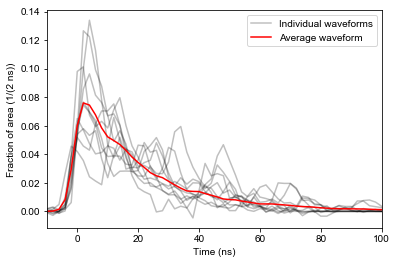

In [108]:
s1_range = (30, 40)
dset  ='nr'
n_singles = 10

ydata, n_data_s1s = real_s1_wv(s1_min = s1_range[0], s1_max = s1_range[1], dset = dset)
tmat, wvs = real_s1_wv_matrix(s1_min = s1_range[0], s1_max = s1_range[1], dset=dset)

for i in range(n_singles):
    # legend hack
    if i == 0:
        plt.plot(tmat[:, i], wvs[:, i] / np.sum(wvs[:, i]), color='black', alpha=0.25, label='Individual waveforms')
    else:
        plt.plot(tmat[:, i], wvs[:, i] / np.sum(wvs[:, i]), color='black', alpha=0.25)
plt.plot(spe_ts, ydata, lw=1.5, color='red', label='Average waveform')
plt.xlim(-10, 100)
plt.xlabel('Time (ns)')
plt.ylabel('Fraction of area (1/(2 ns))')
plt.legend()
plt.savefig('average_wv.png', bbox_inches='tight', dpi=200)
plt.show()

In [109]:
s1_bins = np.linspace(0, 100, 11)

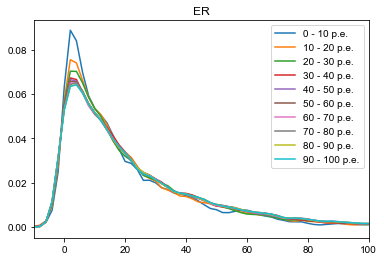

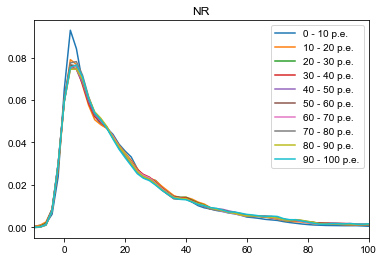

In [110]:
for left, right in zip(s1_bins[:-1], s1_bins[1:]):
    ydata, n_data_s1s = real_s1_wv(s1_min = left, s1_max = right, dset = 'er')
    plt.plot(spe_ts, ydata, label = '%d - %d p.e.' % (left, right))
    #plt.title('Average waveform %.1f - %.1f p.e., %d events.' % (left, right, n_data_s1s))
    #plt.show()
plt.xlim(-10, 100)
plt.title('ER')
plt.legend()
plt.show()

for left, right in zip(s1_bins[:-1], s1_bins[1:]):
    ydata, n_data_s1s = real_s1_wv(s1_min = left, s1_max = right, dset='nr')
    plt.plot(spe_ts, ydata, label = '%d - %d p.e.' % (left, right))
    #plt.title('Average waveform %.1f - %.1f p.e., %d events.' % (left, right, n_data_s1s))
    #plt.show()
plt.xlim(-10, 100)
plt.title('NR')
plt.legend()
plt.show()

# Model-data comparison

## Sigma and residuals

In [111]:
def residuals(ydata, minus, base, plus, **params):
    params = get_params(params)
    sigma = get_sigma(minus, base, plus, **params)
    if 0. in sigma:
        zero_positions = np.where(sigma == 0)
        print('Warning: found zero in error array at positions: ', zero_positions)
        print('Replacing with infinite error instead...')
        for pos in zero_positions:
            sigma[pos] = np.inf
    return (ydata - base) / sigma

def get_sigma(minus, base, plus, **params):
    params = get_params(params)
    if (np.any(minus > base) | np.any(base > plus)):
        raise ValueError('Screw this, negative errors should not be there!')
    sigma_syst = np.abs(plus - minus)/2 + params['error_offset'] + params['error_pct'] * np.abs(base)
    if params['neglect_statistical']:
        print('Neglect!')
        return sigma_syst
    sigma_stat = real_s1_wv_sigma(bootstrap_trials = 25, **params)
    sigma = np.sqrt(sigma_syst**2 + sigma_stat**2)
    return sigma
   

## Plotting

In [112]:
def comparison_plot(ydata, minus, base, plus, log=False, **params):
    params = get_params(params)
    sigmas = get_sigma(minus, base, plus, **params)

    # large subplot
    ax2 = plt.subplot2grid((3,1), (2,0))
    ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2, sharex=ax2)

    #f, (ax1, ax2) = plt.subplots(2, sharex=True)
    plt.sca(ax1)
    # plt.fill_between(spe_ts, minus, plus, alpha=0.5, linewidth=0, step='mid')
    plt.fill_between(spe_ts, base - sigmas, base + sigmas,
                     alpha=0.5, linewidth=0, step='mid')
    plt.plot(spe_ts, base, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')

    plt.grid(alpha=0.1, linestyle='-', which='both')
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.ylabel("Fraction of amplitude")
    plt.axhline(0, c='k', alpha=0.5)
    leg = plt.legend(loc='upper right', numpoints=1)
    leg.get_frame().set_linewidth(0.0)
    leg.get_frame().set_alpha(0.5)
    if log:
        plt.yscale('log')
        plt.ylim(1e-5, 1e-1)
    else:
        plt.ylim(0, None)

    #ax1.set_xticklabels([])

    # Add residuals
    plt.sca(ax2)
    plt.subplot2grid((3,1), (2,0), sharex=ax1)
    plt.xlim(params['t_min'], params['t_max'])

    res = residuals(ydata, minus, base, plus, **params)
    
    plt.plot(spe_ts, res,
             linestyle='', marker='x', c='k', markersize=3)
    plt.ylim(-3, 3)
    plt.grid(which='both', linestyle='-', alpha=0.1)
    plt.axhline(0, c='k', alpha=0.5)

    plt.ylabel("Residual")
    plt.xlabel("Time since alignment point")
#     plt.text(#plt.xlim()[1] * 0.5, plt.ylim()[1] * 0.6,
#              60, 2,
#              'Mean abs. res.: %0.3f' % np.abs(res).mean())

    plt.tight_layout()
    plt.gcf().subplots_adjust(0,0,1,1,0,0)

def comparison_plot_2(ydata, minus, base, plus, **params):
    params = get_params(params)
    res = residuals(ydata, minus, base, plus, **params)
    sigmas = get_sigma(minus, base, plus, **params)
    
#     plt.fill_between(spe_ts, minus - params['error_offset'], plus + params['error_offset'],
#                      alpha=0.5, linewidth=0, step='mid')
    plt.fill_between(spe_ts, base - sigmas, base + sigmas,
                     alpha=0.5, linewidth=0, step='mid')
    plt.plot(spe_ts, base, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')
    plt.yscale('log')
    plt.ylim(2e-5, 1e-1)
    plt.ylabel("Fraction of amplitude")
    plt.xlabel('Time (ns)')
    for _l in (params['t_min'], params['t_max']):
        plt.axvline(_l, ls='dotted', color='black')
    plt.twinx()
    plt.plot(spe_ts, np.abs(res), color='red')
    plt.ylabel('Residual / error')
    plt.ylim(0)
    plt.xlim(params['t_min'] - 20, params['t_max'] + 50)
    
    res = res[(spe_ts >= params['t_min']) & (spe_ts < params['t_max'])]
    chi2 = sum(res**2) / len(spe_ts[(spe_ts >= params['t_min']) & (spe_ts < params['t_max'])])
    print('chi2 = %f' % chi2)
    
def plot_model(plot_type = 0, **params):
    params = get_params(params)
    print(params)
    ydata, _ = real_s1_wv(**params)
    minus, base, plus = s1_models_error(**params)
    if plot_type == 0 or plot_type == 1:
        comparison_plot(ydata, minus, base, plus, **params)
        plt.show()
    if plot_type == 0 or plot_type == 2:
        comparison_plot_2(ydata, minus, base, plus, **params)
        plt.show()
    return

## Residuals function

In [113]:
def gof(verbose=True, mode = 'chi2_ndf', **params):
    '''
    Get the value to minimize given the parameters
    '''
    params = get_params(params)
    # Do not allow unphysical values
    if params['t1'] < 0 or params['t3'] < 0 or not (0 <= params['fs'] <= 1):
        result = float('inf')
    else:
        ydata, _ = real_s1_wv(**params)
        minus, base, plus = s1_models_error(**params)
        res = residuals(ydata, minus, base, plus, **params)
        assert len(res) == len(spe_ts)
        res = res[(spe_ts >= params['t_min']) & (spe_ts < params['t_max'])]
        if mode == 'mean':
            result = np.abs(res).mean()
        elif mode == 'median':
            result = np.median(np.abs(res))
        elif mode == 'chi2':
            result = np.sum(res**2)
        elif mode == 'chi2_ndf':
            result = 1/len(res) * np.sum(res**2)
        elif mode == 'res':
            result = res
        else:
            raise ValueError('Mode unknown, got this: %s' % mode)
    if verbose and (mode != 'res'):
        print('gof={gof}, fs={fs}, t1={t1}, t3={t3}, tts={tts}'.format(gof=result, **params))
    return result

def gof_repeat(iterations, verbose=True, mode = 'chi2_ndf', metamode = 'median', **params):
    params = get_params(params)
    if params['t1'] < 0 or params['t3'] < 0 or not (0 <= params['fs'] <= 1):
        result = float('inf')
    else:
        gofs = np.array([gof(verbose=False, mode = mode, **params) for _ in range(iterations)])
        if metamode == 'median':
            result = np.median(gofs)
        elif metamode == 'mean':
            result = np.mean(gofs)
    if verbose:
        print('gof={gof}, fs={fs}, t1={t1}, t3={t3}, tts={tts}'.format(gof=result, **params))
    return result    


In [114]:
def gof_simultaneous(fs_er, fs_nr, verbose=True, mode='mean', **params):
    params = get_params(params)
    params_er = deepcopy(params)
    params_nr = deepcopy(params)
    params_er['dset'] = 'er'
    params_nr['dset'] = 'nr'
    params_er['fs'] = fs_er
    params_nr['fs'] = fs_nr
    gof_er = gof(verbose=False, mode=mode, **params_er)
    gof_nr = gof(verbose=False, mode=mode, **params_nr)
    if verbose:
        print('gof_er={gof_er}, gof_nr={gof_nr}, fs_er={fs_er}, fs_nr={fs_nr} t1={t1}, t3={t3}, tts={tts}'.format(
            gof_er=gof_er, gof_nr=gof_nr, fs_er = params_er['fs'], fs_nr = params_nr['fs'], **params))    
    return gof_er + gof_nr

In [115]:
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

def minimize_it(param_names, starting_values, **params):
    optresult = optimize.minimize(
        lambda x: gof(**merge_two_dicts(params, {par : x[i] for i, par in enumerate(param_names)})),
        starting_values,
        options=dict(maxfev=1000),
        method='Powell',
    )
    return optresult

# Performing the fit

## Two exponent, fit singlet fraction and t3

In [38]:
p = dict(
    s1_min = 30,
    s1_max = 100,
    dset = 'er',
    n_photons = int(2e5),
    spe_model = 'expnorm',
    error_offset = 1e-4,
    neglect_systematic = True,
    t_max = 200,
    s1_model = 'two_exp',
    t1 = 3.1,
    t3 = 24.5,
    fs = 0.205,
    tts = 1.4,
)

In [47]:
p['verbose'] = False
fit_t3_fs = {}

In [58]:
for dset in xams_data.keys():
    p['dset'] = dset
    print('Working on dataset %s...' % dset)
    fit_t3_fs[dset] = minimize_it(['t3', 'fs'], [p['t3'], p['fs']], **p)
    print('Done! Values found: %f and %f' % (fit_t3_fs[dset].x[0], fit_t3_fs[dset].x[1]))

Working on dataset nr_l...
Done! Values found: 24.531952 and 0.327069
Working on dataset bg_nr...
Done! Values found: 25.558929 and 0.196378
Working on dataset er...
Done! Values found: 26.170878 and 0.200487
Working on dataset er_0...
Done! Values found: 31.999380 and 0.174057
Working on dataset nr...
Done! Values found: 24.258079 and 0.267771
Working on dataset er_l...
Done! Values found: 26.904913 and 0.152669


nr_l
{'s1_sample': 'data', 'nr_l': 'nr_l', 'dset': 'nr_l', 's1_model': 'two_exp', 'error_pct': 0.0, 'er_0': 'er_0', 'fs_r': 0.2, 'fs': 0.3270689154453067, 't_max': 200, 'error_offset': 0.0001, 'spe_model': 'expnorm', 't3': 24.531951756826416, 'neglect_statistical': False, 'bg_nr': 'bg_nr', 'tr': 15, 'er': 'er', 'n_photons': 200000, 'neglect_systematic': True, 't_min': -8.0, 's1_min': 30, 's1_max': 100, 't1': 3.1, 'tts': 1.4, 'verbose': False, 'aft': 0.5, 'f_r': 0.0, 'nr': 'nr', 'er_l': 'er_l'}


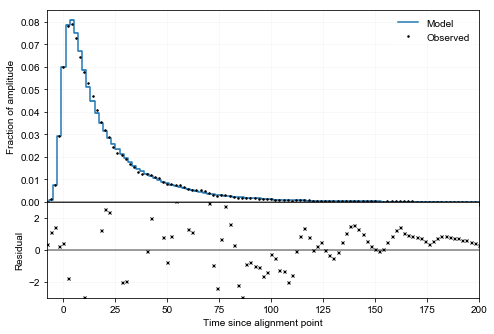

chi2 = 8.205866


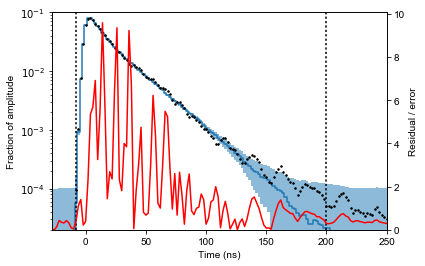

bg_nr
{'s1_sample': 'data', 'nr_l': 'nr_l', 'dset': 'bg_nr', 's1_model': 'two_exp', 'error_pct': 0.0, 'er_0': 'er_0', 'fs_r': 0.2, 'fs': 0.19637762551441215, 't_max': 200, 'error_offset': 0.0001, 'spe_model': 'expnorm', 't3': 25.558928855586689, 'neglect_statistical': False, 'bg_nr': 'bg_nr', 'tr': 15, 'er': 'er', 'n_photons': 200000, 'neglect_systematic': True, 't_min': -8.0, 's1_min': 30, 's1_max': 100, 't1': 3.1, 'tts': 1.4, 'verbose': False, 'aft': 0.5, 'f_r': 0.0, 'nr': 'nr', 'er_l': 'er_l'}


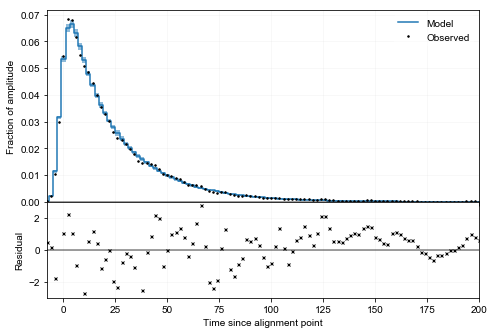

chi2 = 1.175716


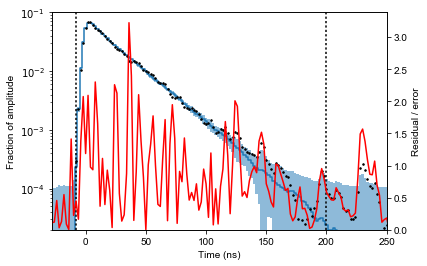

er
{'s1_sample': 'data', 'nr_l': 'nr_l', 'dset': 'er', 's1_model': 'two_exp', 'error_pct': 0.0, 'er_0': 'er_0', 'fs_r': 0.2, 'fs': 0.20048679262227517, 't_max': 200, 'error_offset': 0.0001, 'spe_model': 'expnorm', 't3': 26.170877563964723, 'neglect_statistical': False, 'bg_nr': 'bg_nr', 'tr': 15, 'er': 'er', 'n_photons': 200000, 'neglect_systematic': True, 't_min': -8.0, 's1_min': 30, 's1_max': 100, 't1': 3.1, 'tts': 1.4, 'verbose': False, 'aft': 0.5, 'f_r': 0.0, 'nr': 'nr', 'er_l': 'er_l'}


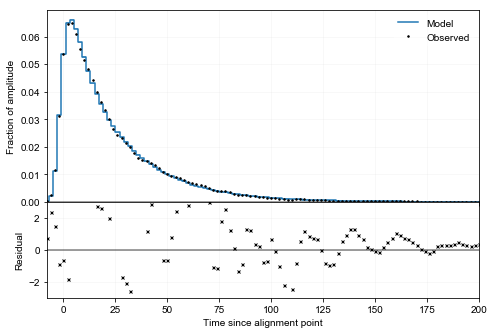

chi2 = 8.631160


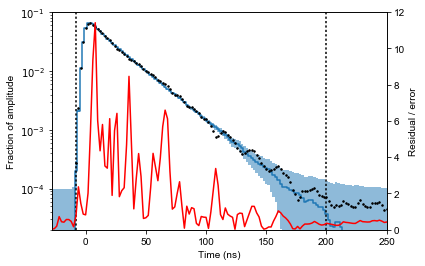

er_0
{'s1_sample': 'data', 'nr_l': 'nr_l', 'dset': 'er_0', 's1_model': 'two_exp', 'error_pct': 0.0, 'er_0': 'er_0', 'fs_r': 0.2, 'fs': 0.17405701102584889, 't_max': 200, 'error_offset': 0.0001, 'spe_model': 'expnorm', 't3': 31.999380268792869, 'neglect_statistical': False, 'bg_nr': 'bg_nr', 'tr': 15, 'er': 'er', 'n_photons': 200000, 'neglect_systematic': True, 't_min': -8.0, 's1_min': 30, 's1_max': 100, 't1': 3.1, 'tts': 1.4, 'verbose': False, 'aft': 0.5, 'f_r': 0.0, 'nr': 'nr', 'er_l': 'er_l'}


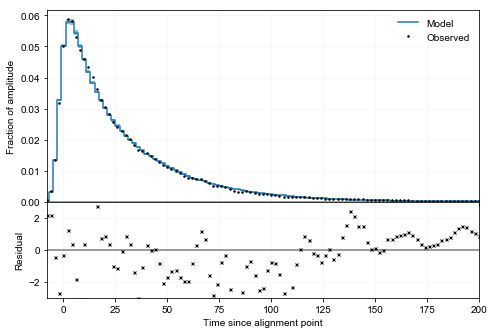

chi2 = 2.578209


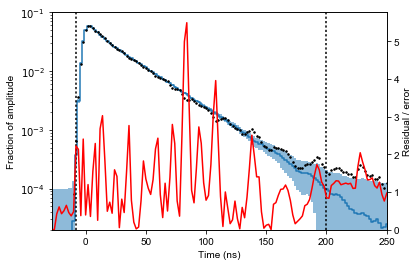

nr
{'s1_sample': 'data', 'nr_l': 'nr_l', 'dset': 'nr', 's1_model': 'two_exp', 'error_pct': 0.0, 'er_0': 'er_0', 'fs_r': 0.2, 'fs': 0.26777087222732593, 't_max': 200, 'error_offset': 0.0001, 'spe_model': 'expnorm', 't3': 24.258079486428642, 'neglect_statistical': False, 'bg_nr': 'bg_nr', 'tr': 15, 'er': 'er', 'n_photons': 200000, 'neglect_systematic': True, 't_min': -8.0, 's1_min': 30, 's1_max': 100, 't1': 3.1, 'tts': 1.4, 'verbose': False, 'aft': 0.5, 'f_r': 0.0, 'nr': 'nr', 'er_l': 'er_l'}


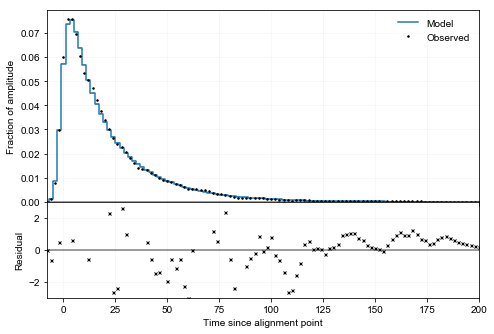

chi2 = 12.885354


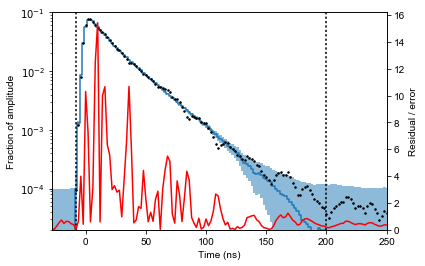

er_l
{'s1_sample': 'data', 'nr_l': 'nr_l', 'dset': 'er_l', 's1_model': 'two_exp', 'error_pct': 0.0, 'er_0': 'er_0', 'fs_r': 0.2, 'fs': 0.15266858023277974, 't_max': 200, 'error_offset': 0.0001, 'spe_model': 'expnorm', 't3': 26.90491334217641, 'neglect_statistical': False, 'bg_nr': 'bg_nr', 'tr': 15, 'er': 'er', 'n_photons': 200000, 'neglect_systematic': True, 't_min': -8.0, 's1_min': 30, 's1_max': 100, 't1': 3.1, 'tts': 1.4, 'verbose': False, 'aft': 0.5, 'f_r': 0.0, 'nr': 'nr', 'er_l': 'er_l'}


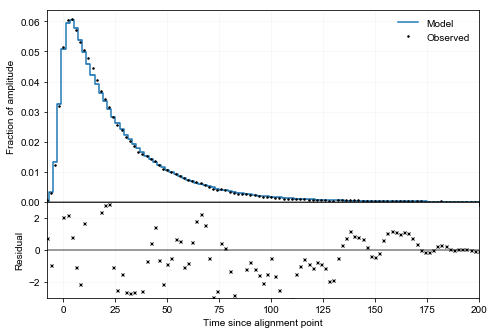

chi2 = 4.098603


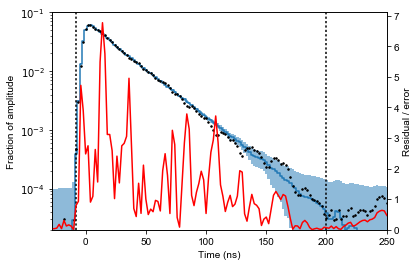

In [65]:
for dset in xams_data.keys():
    print(dset)
    p['t3'], p['fs'] = fit_t3_fs[dset].x
    p['dset'] = dset
    plot_model(**p)
    plt.show()

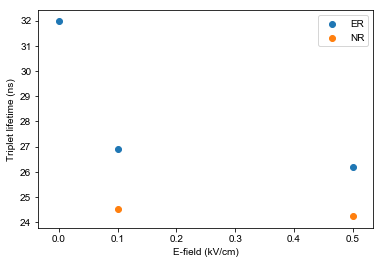

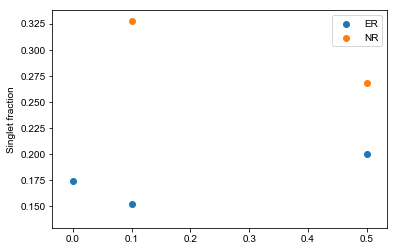

In [76]:
field = [0, 0.1, 0.5]
t3_er = [fit_t3_fs[dset].x[0] for dset in ['er_0', 'er_l', 'er']]
fs_er = [fit_t3_fs[dset].x[1] for dset in ['er_0', 'er_l', 'er']]

field_nr = [0.1, 0.5]
t3_nr = [fit_t3_fs[dset].x[0] for dset in ['nr_l', 'nr']]
fs_nr = [fit_t3_fs[dset].x[1] for dset in ['nr_l', 'nr']]

plt.scatter(field, t3_er, label='ER')
plt.scatter(field_nr, t3_nr, label='NR')
plt.xlabel('E-field (kV/cm)')
plt.ylabel('Triplet lifetime (ns)')
plt.legend()
plt.show()


plt.scatter(field, fs_er, label='ER')
plt.scatter(field_nr, fs_nr, label='NR')
plt.ylabel('Singlet fraction')
plt.legend()

The fit looks pretty reasonable in all cases, given only the requirement that t3 and fs be free. The triplet lifetime seems to be doing something reasonable, but the singlet fraction is a bit weird: it goes in opposite directions for ER and NR, and the difference between zero and 0.1 field is a bit odd in ER. For both these plots, the missing point at 0 field NR would be of considerable interest...

## The difference of two ER field fits

In [129]:
p = dict(
    s1_min = 30,
    s1_max = 100
)

In [143]:
dsets_er = ['er_0', 'er_l', 'er']
L = [200, 168, 143]

In [144]:
pulses_er = []
for dset in dsets_er:
    p['dset'] = dset
    ydata, _ = real_s1_wv(**p)
    pulses_er.append(ydata)


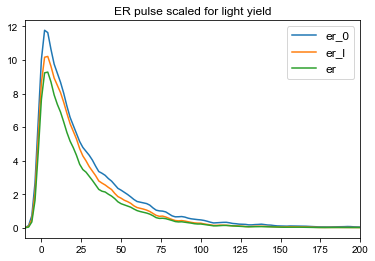

In [153]:
for pulse, l, label in zip(pulses_er, L, dsets_er):
    plt.plot(spe_ts, l * pulse, label=label)
plt.xlim(-10, 200)
plt.legend(fontsize=12)
# plt.yscale('log')
plt.title('ER pulse scaled for light yield')

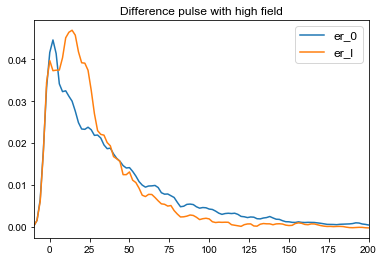

In [204]:
max_p = 2
for pulse, l, label in zip(pulses_er[:max_p], L[:2], dsets_er[:2]):
    plt.plot(spe_ts, (l * pulse - pulses_er[2] * L[2]) / (l - L[2]), label=label)
plt.xlim(-10, 200)
plt.legend(fontsize=12)
# plt.yscale('log')
plt.title('Difference pulse with high field')
x_plot = np.linspace(0, 200, 200)
tr_guess = 50
t3_guess = 24
t1_guess = 2
fs_guess = 0.9
A = 100
toff = 5
# plt.yscale('log')
# plt.ylim(1e-3)

# plt.plot(x_plot - toff, A * (fs_guess * Ir(x_plot, t1_guess, tr_guess) + (1 - fs_guess) * Ir(x_plot, t3_guess, tr_guess) ))
# plt.plot(x_plot - toff, A * (fs_guess * Ir(x_plot, t1_guess, tr_guess) ))
# plt.plot(x_plot - toff, A * ((1 - fs_guess) * Ir(x_plot, t3_guess, tr_guess) ))

## Recombination model

In [123]:
p = dict(
    s1_min = 30,
    s1_max = 100,
    dset = 'er',
    n_photons = int(2e5),
    spe_model = 'expnorm',
    error_offset = 1e-4,
    neglect_systematic = True,
    t_max = 200,
    s1_model = 'recombination',
    t1 = 3.1,
    t3 = 24,
    fs = 0.205,
    tts = 1.4,
    f_r = 0.05,
    fs_r = 0.,
    tr = 15.
)

{'fs': 0.205, 'f_r': 0.05, 's1_min': 30, 't_min': -8.0, 't1': 3.1, 'spe_model': 'expnorm', 'neglect_systematic': True, 'aft': 0.5, 's1_sample': 'data', 'neglect_statistical': False, 'tr': 15.0, 'dset': 'er', 'tts': 1.4, 's1_max': 100, 't_max': 200, 'error_pct': 0.0, 'n_photons': 200000, 's1_model': 'recombination', 't3': 24, 'fs_r': 0.0, 'error_offset': 0.0001}
Remcombination: 0 sing, 10125 trip


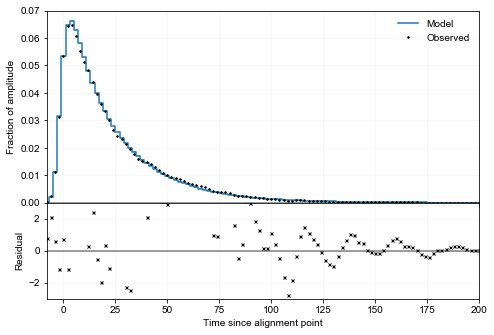

chi2 = 11.840978


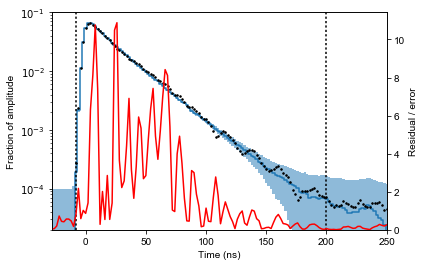

In [124]:
plot_model(**p)

In [137]:
p['dset'] = 'er_0'
p['f_r'] = 0.285
p['fs_r'] = 0.25

{'fs': 0.205, 'f_r': 0.285, 's1_min': 30, 't_min': -8.0, 't1': 3.1, 'spe_model': 'expnorm', 'neglect_systematic': True, 'aft': 0.5, 's1_sample': 'data', 'neglect_statistical': False, 'tr': 15.0, 'dset': 'er_0', 'tts': 1.4, 's1_max': 100, 't_max': 200, 'error_pct': 0.0, 'n_photons': 200000, 's1_model': 'recombination', 't3': 24, 'fs_r': 0.25, 'error_offset': 0.0001}
Remcombination: 14125 sing, 42561 trip


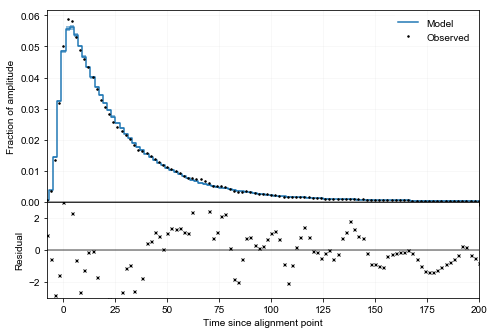

chi2 = 2.874057


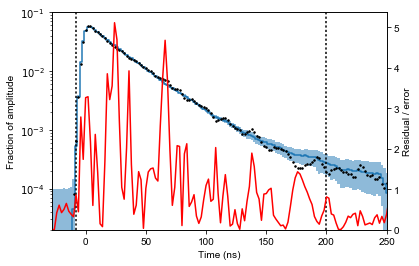

In [138]:
plot_model(**p)

## Complex model, fit simultaneous ER for three fields

What if, instead of making the lifetimes dependent on recoil type and field, we can just make the recombination fraction dependent on this and fit all simultaneous? This appeals to me in a theoretical sense, but does it work? Maybe, if the recombination works according to my recombination model (is it too simplistic? Where are the recombination electrons going? etc.)

In [176]:
def check_combined_model(Linf, plot=False, plot_type = 1, **p):
    # Extract the recombination fractions from Linf
    if Linf > 143:
        return np.inf
    dsets_er = ['er_0', 'er_l', 'er']
    L = [200, 168, 143] # light yield for 0, 100 and 500 field
    frs = [l / Linf -1 for l in L]
    gofs = [] 
    for dset, fr in zip(dsets_er, frs):
        p['dset'] = dset
        p['f_r'] = fr
        if plot:
            plot_model(plot_type=plot_type, **p)
        gofs.append(gof(**p))
    print(gofs)
    # Add penalties!
    # Linf, t3, fs
#     guess_values = [130, 23, 0.25]
#     sigmas = [5, 2, 0.5]
#     prior_Linf = [1/gaus(Linf - guess_values[0], sigmas[0])]
#     prior_thingy = [1/gaus(p[param] - guess_values[i + 1], sigmas[i + 1]) for i, param in enumerate(['t3', 'fs'])]
#     prior_thingy = prior_Linf + prior_thingy
#     print(prior_thingy)
    
    return sum(gofs) #  + sum(prior_thingy)

In [159]:
p = dict(
    s1_min = 30,
    s1_max = 100,
    dset = 'er',
    n_photons = int(2e5),
    spe_model = 'expnorm',
    error_offset = 1e-4,
    neglect_systematic = True,
    t_max = 200,
    s1_model = 'recombination',
    t1 = 3.1,
    t3 = 24.,
    fs = 0.2,
    tts = 1.4,
    # fs_r = 0.8,
    tr = 15,
)

In [160]:
# check_combined_model(Linf = 135, plot=True, **p)

In [161]:
# check_combined_model(Linf = 140, plot=False, **p)

In [162]:
optresult = optimize.minimize(
    lambda x: check_combined_model(Linf = x[0], fs_r = x[1], **p),
    [135, 0.8],
    options=dict(maxfev=1000),
    method='Powell',
)

Remcombination: 77379 sing, 19229 trip
gof=10.837970703550482, fs=0.2, t1=3.1, t3=24.0, tts=1.4
Remcombination: 39128 sing, 9834 trip
gof=8.6349439019833, fs=0.2, t1=3.1, t3=24.0, tts=1.4
Remcombination: 9312 sing, 2395 trip
gof=27.390960864505686, fs=0.2, t1=3.1, t3=24.0, tts=1.4
[10.837970703550482, 8.6349439019833003, 27.390960864505686]
Remcombination: 76715 sing, 19336 trip
gof=13.013349997179088, fs=0.2, t1=3.1, t3=24.0, tts=1.4
Remcombination: 38889 sing, 9799 trip
gof=9.373596075742142, fs=0.2, t1=3.1, t3=24.0, tts=1.4
Remcombination: 9264 sing, 2350 trip
gof=24.542624025665173, fs=0.2, t1=3.1, t3=24.0, tts=1.4
[13.013349997179088, 9.3735960757421424, 24.542624025665173]
Remcombination: 75662 sing, 18581 trip
gof=11.233115511733644, fs=0.2, t1=3.1, t3=24.0, tts=1.4
Remcombination: 37669 sing, 9248 trip
gof=10.842827730235008, fs=0.2, t1=3.1, t3=24.0, tts=1.4
Remcombination: 8253 sing, 2001 trip
gof=27.603419196444023, fs=0.2, t1=3.1, t3=24.0, tts=1.4
[11.233115511733644, 10.842

In [163]:
optresult

   direc: array([[ 1.,  0.],
       [ 0.,  1.]])
     fun: 33.65017585230062
 message: 'Optimization terminated successfully.'
    nfev: 133
     nit: 4
  status: 0
 success: True
       x: array([ 126.08727848,    0.73236042])

{'fs': 0.2, 'n_photons': 200000, 's1_min': 30, 't_min': -8.0, 't1': 3.1, 'f_r': 0.58620284629628339, 'neglect_systematic': True, 'aft': 0.5, 's1_sample': 'data', 'spe_model': 'expnorm', 'tr': 15, 'dset': 'er_0', 'tts': 1.4, 's1_max': 100, 't_max': 200, 'error_pct': 0.0, 'neglect_statistical': False, 's1_model': 'recombination', 't3': 24.0, 'fs_r': 0.73236042008109681, 'error_offset': 0.0001}
Remcombination: 85791 sing, 31489 trip


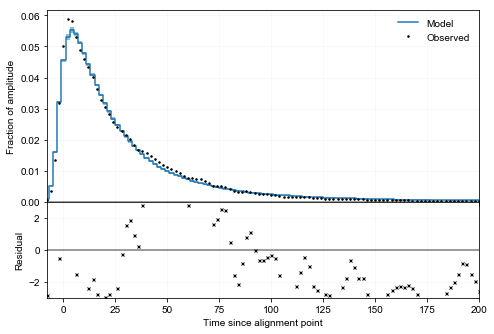

Remcombination: 85919 sing, 31330 trip
gof=11.053541567451239, fs=0.2, t1=3.1, t3=24.0, tts=1.4
{'fs': 0.2, 'n_photons': 200000, 's1_min': 30, 't_min': -8.0, 't1': 3.1, 'f_r': 0.33241039088887803, 'neglect_systematic': True, 'aft': 0.5, 's1_sample': 'data', 'spe_model': 'expnorm', 'tr': 15, 'dset': 'er_l', 'tts': 1.4, 's1_max': 100, 't_max': 200, 'error_pct': 0.0, 'neglect_statistical': False, 's1_model': 'recombination', 't3': 24.0, 'fs_r': 0.73236042008109681, 'error_offset': 0.0001}
Remcombination: 48864 sing, 17763 trip


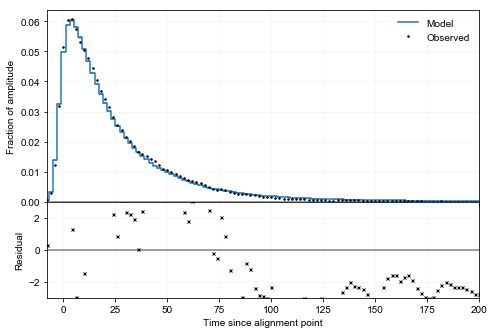

Remcombination: 48799 sing, 17774 trip
gof=10.704920613325053, fs=0.2, t1=3.1, t3=24.0, tts=1.4
{'fs': 0.2, 'n_photons': 200000, 's1_min': 30, 't_min': -8.0, 't1': 3.1, 'f_r': 0.13413503510184266, 'neglect_systematic': True, 'aft': 0.5, 's1_sample': 'data', 'spe_model': 'expnorm', 'tr': 15, 'dset': 'er', 'tts': 1.4, 's1_max': 100, 't_max': 200, 'error_pct': 0.0, 'neglect_statistical': False, 's1_model': 'recombination', 't3': 24.0, 'fs_r': 0.73236042008109681, 'error_offset': 0.0001}
Remcombination: 19597 sing, 7250 trip


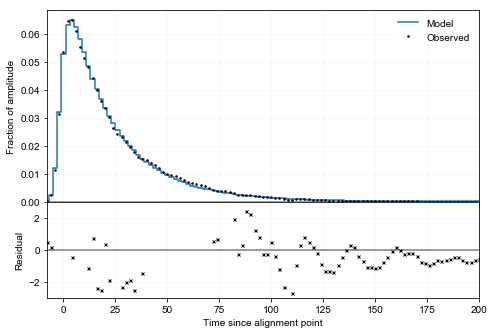

Remcombination: 19722 sing, 7189 trip
gof=13.018676494591757, fs=0.2, t1=3.1, t3=24.0, tts=1.4
[11.053541567451239, 10.704920613325053, 13.018676494591757]


34.77713867536805

In [167]:
L, p['fs_r'] = optresult.x

check_combined_model(Linf = L, plot=True, **p)

In [168]:
del p['fs']

In [169]:
optresult = optimize.minimize(
    lambda x: check_combined_model(Linf = L, fs = x[0], **p),
    [0.2],
    options=dict(maxfev=1000),
    method='Powell',
)

Remcombination: 86220 sing, 31197 trip
gof=10.159542378932603, fs=0.2, t1=3.1, t3=24.0, tts=1.4
Remcombination: 48474 sing, 17744 trip
gof=10.78830525994947, fs=0.2, t1=3.1, t3=24.0, tts=1.4
Remcombination: 19371 sing, 7254 trip
gof=13.055013561171894, fs=0.2, t1=3.1, t3=24.0, tts=1.4
[10.159542378932603, 10.788305259949469, 13.055013561171894]
Remcombination: 86124 sing, 31216 trip
gof=10.85423238168461, fs=0.2, t1=3.1, t3=24.0, tts=1.4
Remcombination: 48958 sing, 17878 trip
gof=11.733358911808052, fs=0.2, t1=3.1, t3=24.0, tts=1.4
Remcombination: 19578 sing, 7190 trip
gof=13.519945897732669, fs=0.2, t1=3.1, t3=24.0, tts=1.4
[10.854232381684611, 11.733358911808052, 13.519945897732669]
Remcombination: 85766 sing, 31244 trip
gof=114.79525016828524, fs=1, t1=3.1, t3=24.0, tts=1.4
Remcombination: 48961 sing, 17847 trip
gof=962.32675434934, fs=1, t1=3.1, t3=24.0, tts=1.4
Remcombination: 19755 sing, 7143 trip
gof=4897.669093150619, fs=1, t1=3.1, t3=24.0, tts=1.4
[114.79525016828524, 962.3267

In [170]:
optresult

   direc: array([[ 1.]])
     fun: 35.890753289575919
 message: 'Optimization terminated successfully.'
    nfev: 44
     nit: 2
  status: 0
 success: True
       x: array(0.1879246639628752)

In [171]:
p['fs'] = optresult.x

In [173]:
check_combined_model(Linf = L, plot=0, **p)

Remcombination: 85508 sing, 31493 trip
gof=10.46847670925167, fs=0.1879246639628752, t1=3.1, t3=24.0, tts=1.4
Remcombination: 48784 sing, 17695 trip
gof=10.794313190594805, fs=0.1879246639628752, t1=3.1, t3=24.0, tts=1.4
Remcombination: 19660 sing, 7265 trip
gof=14.467683800734182, fs=0.1879246639628752, t1=3.1, t3=24.0, tts=1.4
[10.46847670925167, 10.794313190594805, 14.467683800734182]


35.73047370058066

In [174]:
del p['t3'], p['t1']

In [175]:
optresult = optimize.minimize(
    lambda x: check_combined_model(Linf = L, t1 = x[0], t3 = x[1], **p),
    [3.1, 24],
    options=dict(maxfev=1000),
    method='Powell',
)

Remcombination: 85785 sing, 31260 trip
gof=13.244670746438358, fs=0.1879246639628752, t1=3.1, t3=24.0, tts=1.4
Remcombination: 48604 sing, 17640 trip
gof=9.676139648604691, fs=0.1879246639628752, t1=3.1, t3=24.0, tts=1.4
Remcombination: 19772 sing, 7042 trip
gof=15.061681822495354, fs=0.1879246639628752, t1=3.1, t3=24.0, tts=1.4
[13.244670746438358, 9.6761396486046909, 15.061681822495354]
Remcombination: 85939 sing, 31548 trip
gof=10.685475761522426, fs=0.1879246639628752, t1=3.1, t3=24.0, tts=1.4
Remcombination: 48727 sing, 17713 trip
gof=11.714897460794566, fs=0.1879246639628752, t1=3.1, t3=24.0, tts=1.4
Remcombination: 19761 sing, 7204 trip
gof=12.880523935653063, fs=0.1879246639628752, t1=3.1, t3=24.0, tts=1.4
[10.685475761522426, 11.714897460794566, 12.880523935653063]
Remcombination: 85888 sing, 31545 trip
gof=13.474446688551717, fs=0.1879246639628752, t1=4.1, t3=24.0, tts=1.4
Remcombination: 48583 sing, 17942 trip
gof=13.341705434592118, fs=0.1879246639628752, t1=4.1, t3=24.0, t

In [178]:
p['t1'], p['t3'] = optresult.x

{'fs': array(0.1879246639628752), 'n_photons': 200000, 's1_min': 30, 't_min': -8.0, 't1': 1.9011829411582364, 'f_r': 0.58620284629628339, 'neglect_systematic': True, 'aft': 0.5, 's1_sample': 'data', 'spe_model': 'expnorm', 'tr': 15, 'dset': 'er_0', 'tts': 1.4, 's1_max': 100, 't_max': 200, 'error_pct': 0.0, 'neglect_statistical': False, 's1_model': 'recombination', 't3': 24.561754373146599, 'fs_r': 0.73236042008109681, 'error_offset': 0.0001}
Remcombination: 85949 sing, 31471 trip


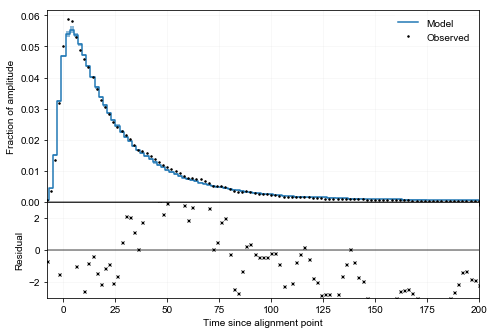

chi2 = 6.974558


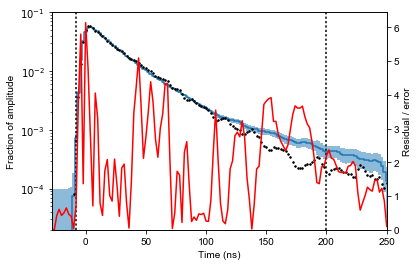

Remcombination: 85747 sing, 31394 trip
gof=7.95878215240067, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.5617543731466, tts=1.4
{'fs': array(0.1879246639628752), 'n_photons': 200000, 's1_min': 30, 't_min': -8.0, 't1': 1.9011829411582364, 'f_r': 0.33241039088887803, 'neglect_systematic': True, 'aft': 0.5, 's1_sample': 'data', 'spe_model': 'expnorm', 'tr': 15, 'dset': 'er_l', 'tts': 1.4, 's1_max': 100, 't_max': 200, 'error_pct': 0.0, 'neglect_statistical': False, 's1_model': 'recombination', 't3': 24.561754373146599, 'fs_r': 0.73236042008109681, 'error_offset': 0.0001}
Remcombination: 48710 sing, 17689 trip


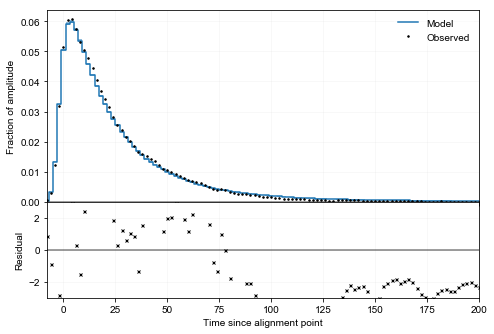

chi2 = 12.742950


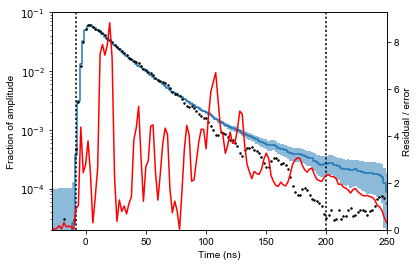

Remcombination: 48909 sing, 17665 trip
gof=11.702767160336876, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.5617543731466, tts=1.4
{'fs': array(0.1879246639628752), 'n_photons': 200000, 's1_min': 30, 't_min': -8.0, 't1': 1.9011829411582364, 'f_r': 0.13413503510184266, 'neglect_systematic': True, 'aft': 0.5, 's1_sample': 'data', 'spe_model': 'expnorm', 'tr': 15, 'dset': 'er', 'tts': 1.4, 's1_max': 100, 't_max': 200, 'error_pct': 0.0, 'neglect_statistical': False, 's1_model': 'recombination', 't3': 24.561754373146599, 'fs_r': 0.73236042008109681, 'error_offset': 0.0001}
Remcombination: 19502 sing, 7074 trip


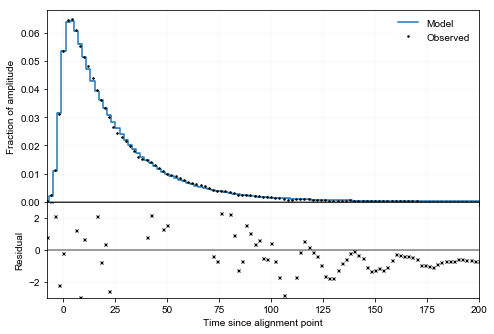

chi2 = 9.876022


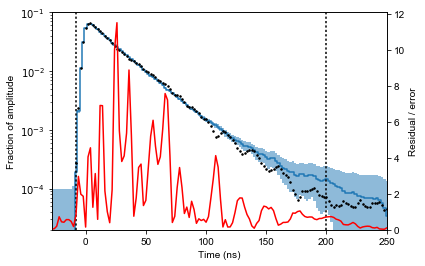

Remcombination: 19488 sing, 7278 trip
gof=10.387435226914674, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.5617543731466, tts=1.4
[7.9587821524006701, 11.702767160336876, 10.387435226914674]


30.048984539652217

In [180]:
check_combined_model(L, plot=True, plot_type=0, **p)

In [181]:
del p['tr']

In [182]:
optresult = optimize.minimize(
    lambda x: check_combined_model(Linf = L, tr = x[0], **p),
    [15],
    options=dict(maxfev=1000),
    method='Powell',
)

Remcombination: 86094 sing, 31295 trip
gof=8.782937366638674, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.5617543731466, tts=1.4
Remcombination: 48697 sing, 17792 trip
gof=12.39299890409535, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.5617543731466, tts=1.4
Remcombination: 19873 sing, 7171 trip
gof=8.665691567013658, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.5617543731466, tts=1.4
[8.7829373666386736, 12.39299890409535, 8.6656915670136581]
Remcombination: 86092 sing, 31628 trip
gof=8.943797646147088, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.5617543731466, tts=1.4
Remcombination: 48915 sing, 17759 trip
gof=11.390632043216149, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.5617543731466, tts=1.4
Remcombination: 19376 sing, 7219 trip
gof=9.850005880226409, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.5617543731466, tts=1.4
[8.9437976461470878, 11.390632043216149, 9.8500058802264086]
Remcombination: 85858 sing, 31320 trip
gof=9.3078798971753

In [183]:
optresult

   direc: array([[ 1.]])
     fun: 24.927167418091898
 message: 'Optimization terminated successfully.'
    nfev: 29
     nit: 2
  status: 0
 success: True
       x: array(13.726410919523028)

In [185]:
p['tr'] = optresult.x

{'fs': array(0.1879246639628752), 'n_photons': 200000, 's1_min': 30, 't_min': -8.0, 't1': 1.9011829411582364, 'f_r': 0.58620284629628339, 'neglect_systematic': True, 'aft': 0.5, 's1_sample': 'data', 'spe_model': 'expnorm', 'tr': array(13.726410919523028), 'dset': 'er_0', 'tts': 1.4, 's1_max': 100, 't_max': 200, 'error_pct': 0.0, 'neglect_statistical': False, 's1_model': 'recombination', 't3': 24.561754373146599, 'fs_r': 0.73236042008109681, 'error_offset': 0.0001}
Remcombination: 85587 sing, 31546 trip


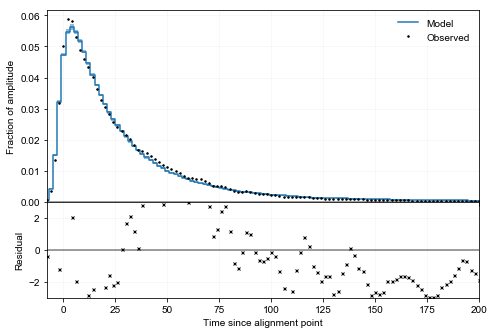

chi2 = 7.367124


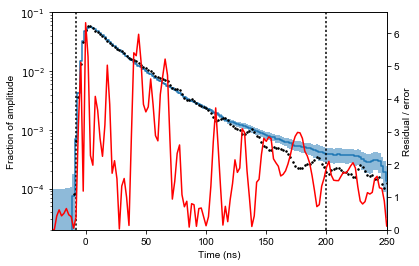

Remcombination: 85503 sing, 31437 trip
gof=8.198252583183963, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.5617543731466, tts=1.4
{'fs': array(0.1879246639628752), 'n_photons': 200000, 's1_min': 30, 't_min': -8.0, 't1': 1.9011829411582364, 'f_r': 0.33241039088887803, 'neglect_systematic': True, 'aft': 0.5, 's1_sample': 'data', 'spe_model': 'expnorm', 'tr': array(13.726410919523028), 'dset': 'er_l', 'tts': 1.4, 's1_max': 100, 't_max': 200, 'error_pct': 0.0, 'neglect_statistical': False, 's1_model': 'recombination', 't3': 24.561754373146599, 'fs_r': 0.73236042008109681, 'error_offset': 0.0001}
Remcombination: 48615 sing, 17795 trip


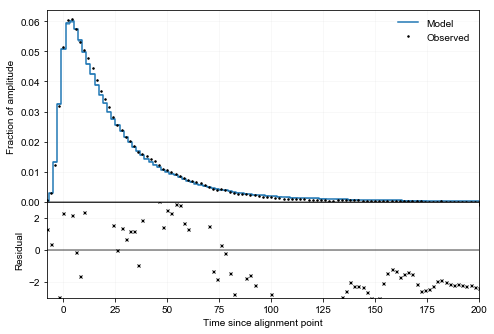

chi2 = 10.125217


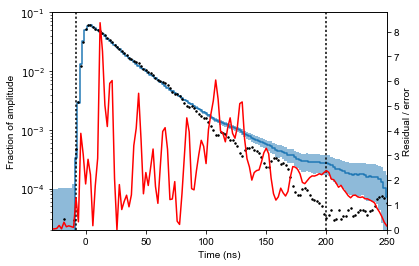

Remcombination: 48693 sing, 17967 trip
gof=9.754585703225947, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.5617543731466, tts=1.4
{'fs': array(0.1879246639628752), 'n_photons': 200000, 's1_min': 30, 't_min': -8.0, 't1': 1.9011829411582364, 'f_r': 0.13413503510184266, 'neglect_systematic': True, 'aft': 0.5, 's1_sample': 'data', 'spe_model': 'expnorm', 'tr': array(13.726410919523028), 'dset': 'er', 'tts': 1.4, 's1_max': 100, 't_max': 200, 'error_pct': 0.0, 'neglect_statistical': False, 's1_model': 'recombination', 't3': 24.561754373146599, 'fs_r': 0.73236042008109681, 'error_offset': 0.0001}
Remcombination: 19869 sing, 7267 trip


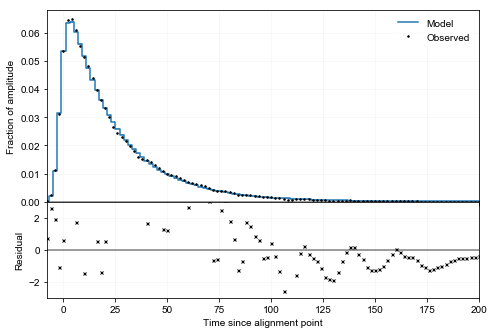

chi2 = 9.148095


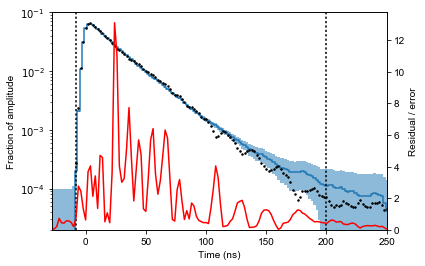

Remcombination: 19672 sing, 7169 trip
gof=8.678007253647706, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.5617543731466, tts=1.4
[8.1982525831839634, 9.7545857032259473, 8.6780072536477064]


26.630845540057617

In [186]:
check_combined_model(L, plot=True, plot_type=0, **p)

In [187]:
del p['t3']

In [188]:
L

126.08727847575835

In [189]:
optresult = optimize.minimize(
    lambda x: check_combined_model(Linf = x[0], t3 = x[1], **p),
    [126, 24.56],
    options=dict(maxfev=1000),
    method='Powell',
)

Remcombination: 86098 sing, 31144 trip
gof=7.6790171750821345, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.56, tts=1.4
Remcombination: 48848 sing, 17828 trip
gof=9.92989191165922, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.56, tts=1.4
Remcombination: 19616 sing, 7179 trip
gof=8.915440674334683, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.56, tts=1.4
[7.6790171750821345, 9.9298919116592206, 8.9154406743346826]
Remcombination: 85884 sing, 31900 trip
gof=8.844458745659203, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.56, tts=1.4
Remcombination: 48900 sing, 17917 trip
gof=9.92294926074869, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.56, tts=1.4
Remcombination: 19936 sing, 7176 trip
gof=9.679023919872924, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.56, tts=1.4
[8.8444587456592032, 9.9229492607486893, 9.6790239198729235]
Remcombination: 84090 sing, 30781 trip
gof=8.231944108197583, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.56, tts=1.4

In [190]:
optresult

   direc: array([[ 0.        ,  1.        ],
       [-0.053281  , -0.01120906]])
     fun: 24.322097245205551
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 2
  status: 0
 success: True
       x: array([ 127.73775923,   24.92686069])

In [191]:
L, p['t3'] = optresult.x

{'fs': array(0.1879246639628752), 'n_photons': 200000, 's1_min': 30, 't_min': -8.0, 't1': 1.9011829411582364, 'f_r': 0.56570775315451516, 'neglect_systematic': True, 'aft': 0.5, 's1_sample': 'data', 'spe_model': 'expnorm', 'tr': array(13.726410919523028), 'dset': 'er_0', 'tts': 1.4, 's1_max': 100, 't_max': 200, 'error_pct': 0.0, 'neglect_statistical': False, 's1_model': 'recombination', 't3': 24.926860689649974, 'fs_r': 0.73236042008109681, 'error_offset': 0.0001}
Remcombination: 82569 sing, 30279 trip


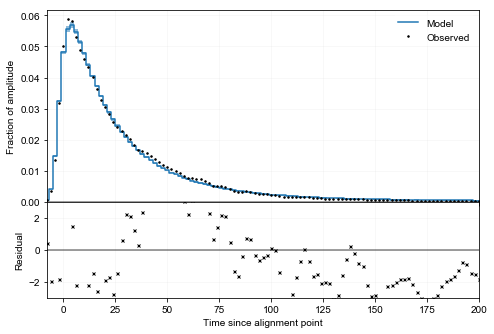

chi2 = 6.466851


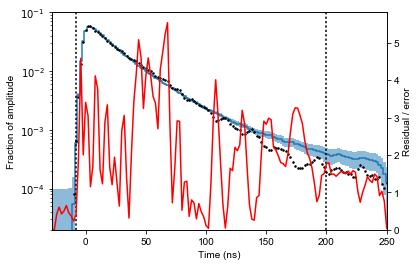

Remcombination: 82747 sing, 30083 trip
gof=6.7664905127406145, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.926860689649974, tts=1.4
{'fs': array(0.1879246639628752), 'n_photons': 200000, 's1_min': 30, 't_min': -8.0, 't1': 1.9011829411582364, 'f_r': 0.31519451264979281, 'neglect_systematic': True, 'aft': 0.5, 's1_sample': 'data', 'spe_model': 'expnorm', 'tr': array(13.726410919523028), 'dset': 'er_l', 'tts': 1.4, 's1_max': 100, 't_max': 200, 'error_pct': 0.0, 'neglect_statistical': False, 's1_model': 'recombination', 't3': 24.926860689649974, 'fs_r': 0.73236042008109681, 'error_offset': 0.0001}
Remcombination: 46140 sing, 16546 trip


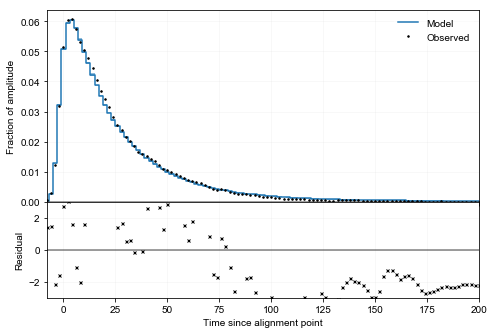

chi2 = 9.597658


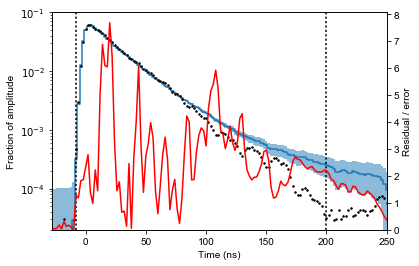

Remcombination: 46313 sing, 16758 trip
gof=8.994116187119287, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.926860689649974, tts=1.4
{'fs': array(0.1879246639628752), 'n_photons': 200000, 's1_min': 30, 't_min': -8.0, 't1': 1.9011829411582364, 'f_r': 0.1194810435054785, 'neglect_systematic': True, 'aft': 0.5, 's1_sample': 'data', 'spe_model': 'expnorm', 'tr': array(13.726410919523028), 'dset': 'er', 'tts': 1.4, 's1_max': 100, 't_max': 200, 'error_pct': 0.0, 'neglect_statistical': False, 's1_model': 'recombination', 't3': 24.926860689649974, 'fs_r': 0.73236042008109681, 'error_offset': 0.0001}
Remcombination: 17559 sing, 6518 trip


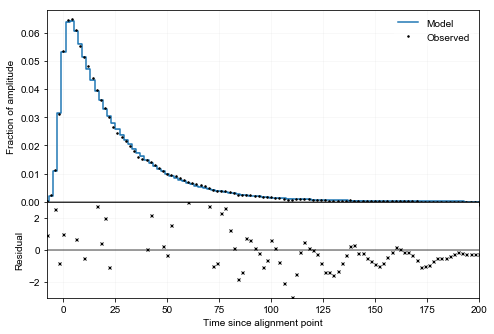

chi2 = 8.088747


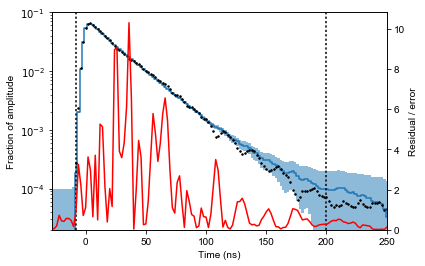

Remcombination: 17220 sing, 6341 trip
gof=8.313967661595735, fs=0.1879246639628752, t1=1.9011829411582364, t3=24.926860689649974, tts=1.4
[6.7664905127406145, 8.9941161871192872, 8.3139676615957345]


24.074574361455639

In [192]:
check_combined_model(L, plot=True, plot_type=0, **p)

In [193]:
p

{'dset': 'er',
 'error_offset': 0.0001,
 'fs': array(0.1879246639628752),
 'fs_r': 0.73236042008109681,
 'n_photons': 200000,
 'neglect_systematic': True,
 's1_max': 100,
 's1_min': 30,
 's1_model': 'recombination',
 'spe_model': 'expnorm',
 't1': 1.9011829411582364,
 't3': 24.926860689649974,
 't_max': 200,
 'tr': array(13.726410919523028),
 'tts': 1.4}

In [ ]:
optresult = optimize.minimize(
    lambda x: check_combined_model(Linf = x[0], t3 = x[1], **p),
    [126, 24.56],
    options=dict(maxfev=1000),
    method='Powell',
)

In [206]:
def fcheck(x):
    print(x)
    return (x - 42)**2 + 0.1

In [207]:
fcheck(42)

42


0.1

In [218]:
optresult = optimize.minimize(
    lambda x: fcheck(x[0]),
    [12],
    options = dict(maxfev = 1000),
    method = 'Powell'
)

12.0
12.0
13.0
14.618034
42.0
86.3049519748
42.0
58.922985286
31.5410199748
41.7
42.3
72.0
42.0
43.0
40.381966
42.0
41.3819660252
42.381966
42.0
42.0
41.7639320348
41.9098300636
41.9655581501
41.9868443843
41.9949750021
41.9980806216
41.9992668627
41.9997199665
41.9998930367
41.9999591436
41.9999843942
41.9999940391
41.9999977231
41.9999991303
41.9999996678
41.9999998731
41.9999999515
41.9999999815
41.9999999929
41.9999999973
41.9999999989
41.9999999983
41.9999999979
41.9999999977
41.9999999975
41.9999999974
41.9999999974
41.9999999973


In [217]:
optresult.x

array([ 41.99999938])

In [213]:
optresult

   direc: array([[ 0.05990637]])
     fun: array(0.10000000000115525)
 message: 'Optimization terminated successfully.'
    nfev: 43
     nit: 2
  status: 0
 success: True
       x: array(35.526979149950385)

# Old fit shit

## The error definition

In earlier analyses, the error definition seemed to cause instabilities in the fit procedure. Here, we load `cust_params` that are close to a fit optimum. Here we check what a change in error definition does. Do we need an ad-hoc error, or can we suffice with an error based on systematics and statistics?

In [45]:
cust_params = dict(
    s1_min = 30,
    s1_max = 100,
    dset = 'er',
    fs = 0.19752269,
    t3 = 25.31125617,
    tts = 1.69178651
)

Try different settings and check their spread in chi2

In [130]:
iterations = 100
gofs1 = [gof(mode='chi2_ndf', verbose=False, error_offset = 0., error_pct = 0., **cust_params) for i in range(iterations)]
gofs2 = [gof(mode='chi2_ndf', verbose=False, error_offset = 1e-5, error_pct = 0., **cust_params) for i in range(iterations)]
gofs3 = [gof(mode='chi2_ndf', verbose=False, error_offset = 0., error_pct = 0.5e-2, **cust_params) for i in range(iterations)]
gofs4 = [gof(mode='chi2_ndf', verbose=False, error_offset = 1e-5, error_pct = 0.5e-2, **cust_params) for i in range(iterations)]

5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168


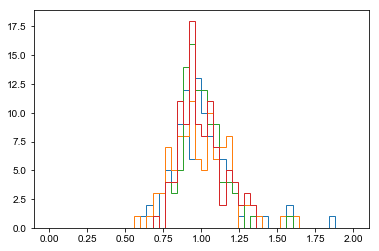

In [137]:
for gofs in [gofs1, gofs2, gofs3, gofs4]:
    plt.hist(gofs / np.mean(gofs), histtype='step', range=(0, 2), bins=50)

Aha, the error pct and offset does not do so much! What about turning off the statistical errors?

In [47]:
iterations = 100
gofs5 = [gof(mode='chi2_ndf', verbose=False, error_offset = 0., error_pct = 0., neglect_statistical = True,
             **cust_params) for i in range(iterations)]
gofs1 = [gof(mode='chi2_ndf', verbose=False, error_offset = 0., error_pct = 0., neglect_statistical = False,
             **cust_params) for i in range(iterations)]

Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!
Neglect!


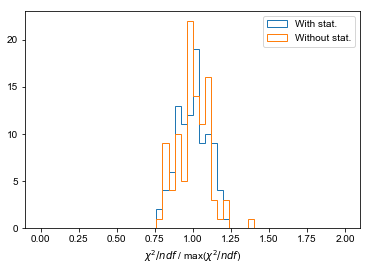

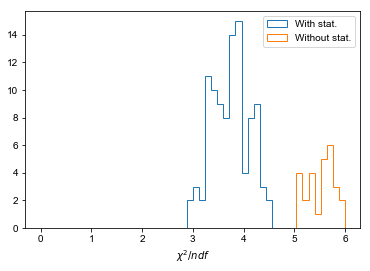

In [56]:
plt.hist(gofs1 / np.mean(gofs1), histtype='step', range=(0, 2), bins=50, label='With stat.')
plt.hist(gofs5 / np.mean(gofs5), histtype='step', range=(0, 2), bins=50, label='Without stat.')
plt.legend()
plt.xlabel('$\chi^2/ndf$ / max($\chi^2/ndf$)')
plt.show()

plt.hist(gofs1, histtype='step', range = (0, 6), bins=50, label='With stat.')
plt.hist(gofs5, histtype='step', range=(0, 6), bins=50, label='Without stat.')
plt.legend()
plt.xlabel('$\chi^2/ndf$')
plt.show()

Conclusion: it seems that the statistical error cannot be neglected! Including the statistical error makes everything more stable, yay! This is probably the highest stats that we'll get.

### Number of photons

How many photons do we need? And how does the spread in chi2 depend on the number of photons simulated? If it has any influence this is bad.

In [105]:
n_photons_scan = np.array([int(_i) for _i in np.logspace(4, 6, 6)])

In [106]:
iterations = 40

const_gofs = []
for n_photons in n_photons_scan:
    print(n_photons)
    const_gofs.append([gof(verbose = False, mode='chi2_ndf', n_photons = n_photons, **cust_params)
                       for _ in range(iterations)])

10000
25118
63095
158489
398107
1000000


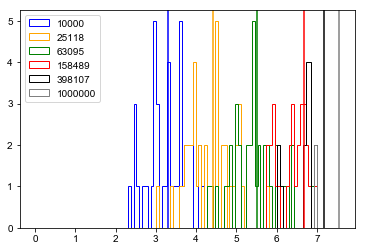

In [107]:
for gofs, n_photons, c in zip(const_gofs, n_photons_scan, ['blue', 'orange', 'green', 'red', 'black', 'gray']):
    plt.hist(gofs, label="%d" % n_photons, histtype='step', range=(0, 7), bins=100, color = c)
    plt.axvline(np.mean(gofs), color = c)
plt.legend()
plt.show()

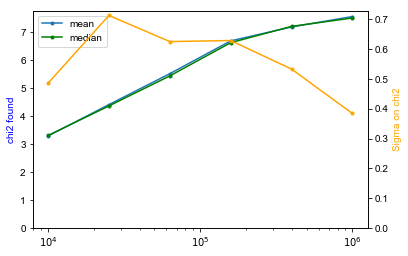

In [108]:
plt.plot(n_photons_scan, np.average(const_gofs, axis=1), marker='.', label='mean')
plt.plot(n_photons_scan, np.median(const_gofs, axis=1), marker='.', color='green', label='median')
plt.ylim(0)
plt.legend()
plt.ylabel('chi2 found', color='blue')
plt.twinx()
plt.plot(n_photons_scan, np.std(const_gofs, axis = 1), marker='.', color='orange')
plt.ylabel('Sigma on chi2', color='orange')
plt.ylim(0)
plt.xscale('log')
plt.xlabel('Number of photons simulated')

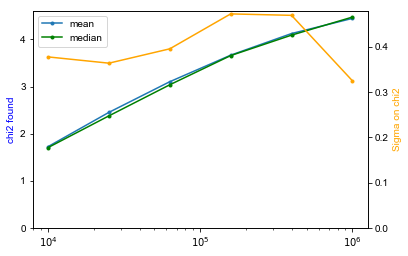

In [83]:
plt.plot(n_photons_scan, np.average(const_gofs, axis=1), marker='.', label='mean')
plt.plot(n_photons_scan, np.median(const_gofs, axis=1), marker='.', color='green', label='median')
plt.ylim(0)
plt.legend()
plt.ylabel('chi2 found', color='blue')
plt.twinx()
plt.plot(n_photons_scan, np.std(const_gofs, axis = 1), marker='.', color='orange')
plt.ylabel('Sigma on chi2', color='orange')
plt.ylim(0)
plt.xscale('log')
plt.xlabel('Number of photons simulated')

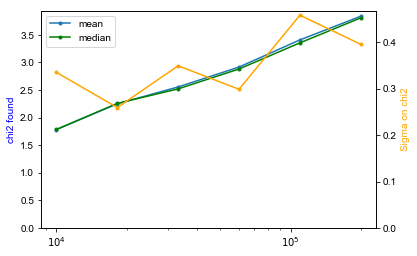

In [55]:
plt.plot(n_photons_scan, np.average(const_gofs, axis=1), marker='.', label='mean')
plt.plot(n_photons_scan, np.median(const_gofs, axis=1), marker='.', color='green', label='median')
plt.ylim(0)
plt.legend()
plt.ylabel('chi2 found', color='blue')
plt.twinx()
plt.plot(n_photons_scan, np.std(const_gofs, axis = 1), marker='.', color='orange')
plt.ylabel('Sigma on chi2', color='orange')
plt.ylim(0)
plt.xscale('log')
plt.xlabel('Number of photons simulated')

Hmmm. Conclusion?

In [86]:
def sigma_from_params(mode, **params):
    minus, base, plus = s1_models_error(mode=mode, **params)
    return get_sigma(minus, base, plus)

In [87]:
cust_params

{'dset': 'er',
 'fs': 0.19752269,
 's1_max': 100,
 's1_min': 30,
 't3': 25.31125617,
 'tts': 1.69178651}

In [75]:
n_photons_scan = [int(1e4), int(1e5), int(1e6), int(1e7)]
sigmas_per_n_photons = []
for n_photons in n_photons_scan:
    print(n_photons)
    sigmas_per_n_photons.append(sigma_from_params(mode='extreme', n_photons = n_photons, **cust_params))


10000
100000
1000000
10000000


In [93]:
n_photons_scan = [int(1e4), int(1e5), int(1e6), int(1e7)]
sigmas_per_n_photons_std = []
for n_photons in n_photons_scan:
    print(n_photons)
    sigmas_per_n_photons_std.append(sigma_from_params(mode='std', n_photons = n_photons, **cust_params))


10000
100000
1000000
10000000


In [ ]:
n_photons_scan = [int(1e4), int(1e5), int(1e6), int(1e7)]
sigmas_per_n_photons_sys = []
for n_photons in n_photons_scan:
    print(n_photons)
    sigmas_per_n_photons_sys.append(sigma_from_params(mode='extreme', 
                                                      n_photons = n_photons, neglect_statistical=True, **cust_params))

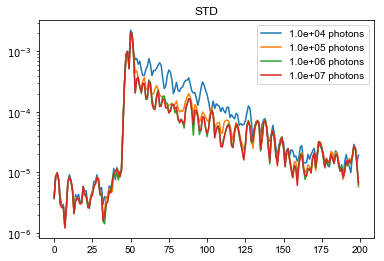

In [94]:
for n_photons, sigmas in zip(n_photons_scan, sigmas_per_n_photons_std):
    plt.plot(sigmas, label = '%.1e photons' % n_photons)
plt.legend()
plt.title('STD')
plt.yscale('log')

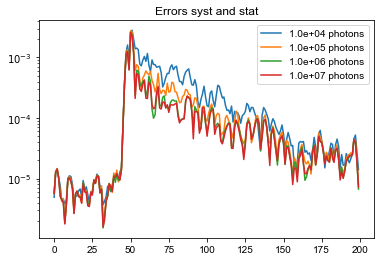

In [95]:
for n_photons, sigmas in zip(n_photons_scan, sigmas_per_n_photons):
    plt.plot(sigmas, label = '%.1e photons' % n_photons)
plt.legend()
plt.title('Errors syst and stat')
plt.yscale('log')

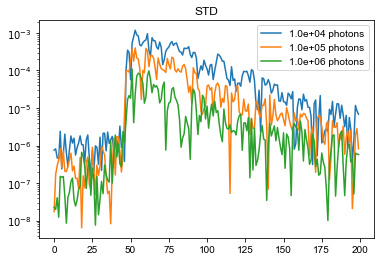

In [102]:
for n_photons, sigmas in zip(n_photons_scan, sigmas_per_n_photons[:-1]):
    plt.plot(np.abs(sigmas - sigmas_per_n_photons[-1]), label = '%.1e photons' % n_photons)
plt.legend()
plt.title('STD')
plt.yscale('log')

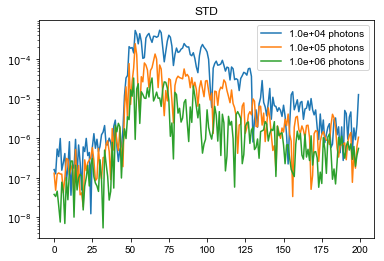

In [96]:
for n_photons, sigmas in zip(n_photons_scan, sigmas_per_n_photons_std[:-1]):
    plt.plot(np.abs(sigmas - sigmas_per_n_photons_std[-1]), label = '%.1e photons' % n_photons)
plt.legend()
plt.title('STD')
plt.yscale('log')

In [ ]:
for n_photons, sigmas in zip(n_photons_scan, sigmas_per_n_photons_std[:-1]):
    plt.plot(np.abs(sigmas - sigmas_per_n_photons_std[-1]), label = '%.1e photons' % n_photons)
plt.legend()
plt.title('STD')
plt.yscale('log')

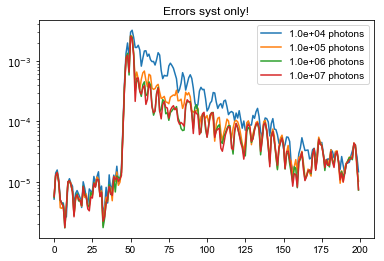

In [91]:
for n_photons, sigmas in zip(n_photons_scan, sigmas_per_n_photons_sys):
    plt.plot(sigmas, label = '%.1e photons' % n_photons)
plt.legend()
plt.title('Errors syst only!')
plt.yscale('log')

## Fit three parameters

Let's try the fit, for three floating parameters: tts, t3, fs.

### expnorm fit

In [33]:
cust_params = dict(
    s1_min = 30,
    s1_max = 100,
    dset = 'er',
    n_photons = int(2e5),
    spe_model = 'expnorm',
    error_offset = 1e-4,
    neglect_systematic = True,
    t_max = 200,
)

In [34]:
from scipy import optimize
optresult = optimize.minimize(
    lambda x: gof(fs=x[0], t3=x[1], tts=x[2], **cust_params),
    [0.2, 26.8, 1.4],
    options=dict(maxfev=1000),
    method='Powell',
)
print('Done')

gof=7.2248304668216194, fs=0.2, t1=3.1, t3=26.8, tts=1.4
gof=6.024913317959224, fs=0.2, t1=3.1, t3=26.8, tts=1.4
gof=inf, fs=1.2, t1=3.1, t3=26.8, tts=1.4
gof=inf, fs=-1.418034, t1=3.1, t3=26.8, tts=1.4
gof=7.295289012618371, fs=0.2, t1=3.1, t3=26.8, tts=1.4
gof=inf, fs=-0.418033974844, t1=3.1, t3=26.8, tts=1.4


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


gof=1956.7961838595425, fs=0.581966, t1=3.1, t3=26.8, tts=1.4
gof=inf, fs=-0.036067965235263316, t1=3.1, t3=26.8, tts=1.4
gof=266.3562824256455, fs=0.34589802515600004, t1=3.1, t3=26.8, tts=1.4
gof=7.496240535940441, fs=0.20997716040795256, t1=3.1, t3=26.8, tts=1.4
gof=8.419711414861283, fs=0.20420885375489836, t1=3.1, t3=26.8, tts=1.4
gof=80.55260062654925, fs=0.10983006359094741, t1=3.1, t3=26.8, tts=1.4
gof=18.45875550066387, fs=0.16555815006957983, t1=3.1, t3=26.8, tts=1.4
gof=9.176883481431386, fs=0.18684438434947714, t1=3.1, t3=26.8, tts=1.4
gof=7.571811661838314, fs=0.19497500211243238, t1=3.1, t3=26.8, tts=1.4
gof=6.486376989571113, fs=0.20297874564056373, t1=3.1, t3=26.8, tts=1.4
gof=7.6100419547823295, fs=0.20184096608322016, t1=3.1, t3=26.8, tts=1.4
gof=7.7955265160640295, fs=0.20344860511656368, t1=3.1, t3=26.8, tts=1.4
gof=7.000650153134381, fs=0.20254415253416344, t1=3.1, t3=26.8, tts=1.4
gof=7.484083330620107, fs=0.20315821598517353, t1=3.1, t3=26.8, tts=1.4
gof=6.407799

   direc: array([[ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.00354623, -0.00595968,  0.00353978]])
     fun: 9.4653848467595871
 message: 'Optimization terminated successfully.'
    nfev: 125
     nit: 2
  status: 0
 success: True
       x: array([  0.21326158,  26.15967904,   1.45188996])
[  0.21326158  26.15967904   1.45188996]


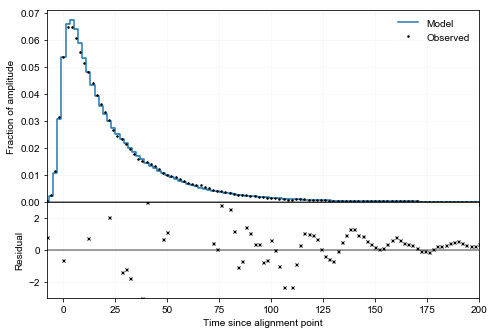

In [68]:
fit = optresult.x
print(optresult)
print(fit)
ydata, _ = real_s1_wv(**cust_params)
minus, base, plus = s1_models_error(fs=fit[0], t3=fit[1], tts = fit[2], **cust_params)
comparison_plot(ydata, minus, base, plus, **cust_params)
plt.show()
# comparison_plot_2(ydata, minus, base, plus, error_offset = 1e-3, **cust_params)
# # plt.ylim(0, 10)
# plt.show()

In [ ]:
[  0.20212231  26.82873125   1.39218689]
[  0.21326158  26.15967904   1.45188996]


chi2 = 6.962514


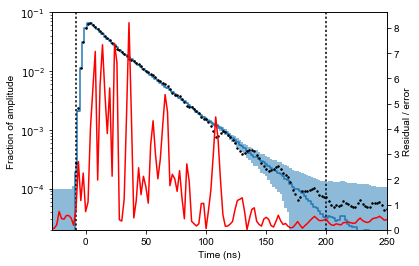

In [117]:
comparison_plot_2(ydata, minus, base, plus,  **cust_params)
# plt.ylim(0, 10)
#plt.xlim(-10, 10)
plt.show()

### Playing with other model

In [108]:
p = dict(
    s1_min = 30,
    s1_max = 100,
    dset = 'er_0',
    n_photons = int(2e5),
    spe_model = 'expnorm',
    error_offset = 1e-4,
    neglect_systematic = True,
    t_max = 200,
    s1_model = 'recombination',
    t1 = 3.1,
    t3 = 24.5,
    fs = 0.305,
    tts = 1.4,
    f_r = 0.5,
    fs_r = 0.5,
    tr = 15,
)


In [120]:
p = dict(
    s1_min = 30,
    s1_max = 100,
    dset = 'er_0',
    n_photons = int(2e5),
    spe_model = 'expnorm',
    error_offset = 1e-4,
    neglect_systematic = True,
    t_max = 200,
    s1_model = 'recombination',
    t1 = 3.1,
    t3 = 24.5,
    fs = 0.205,
    tts = 1.4,
    f_r = 0.285,
    # fs_r = 0.5,
    # tr = 15,
)
# tr, fs_r, f_r = [ 49.75854112,   0.91127712,   0.22594656]

optresult = optimize.minimize(
    lambda x: gof(tr=x[0], fs_r=x[1], **p),
    [50., 0.9],
    options=dict(maxfev=1000),
    method='Powell',
)

Remcombination: 51271 sing, 5537 trip
gof=5.733283698038321, fs=0.205, t1=3.1, t3=24.5, tts=1.4
Remcombination: 51717 sing, 5761 trip
gof=5.3592356794884255, fs=0.205, t1=3.1, t3=24.5, tts=1.4
Remcombination: 50988 sing, 5674 trip
gof=6.78998751261188, fs=0.205, t1=3.1, t3=24.5, tts=1.4
Remcombination: 51332 sing, 5594 trip
gof=4.494204180039294, fs=0.205, t1=3.1, t3=24.5, tts=1.4
Remcombination: 51236 sing, 5638 trip
gof=4.851794744102024, fs=0.205, t1=3.1, t3=24.5, tts=1.4
Remcombination: 51428 sing, 5633 trip
gof=4.088934136928208, fs=0.205, t1=3.1, t3=24.5, tts=1.4
Remcombination: 51324 sing, 5686 trip
gof=4.674824198116812, fs=0.205, t1=3.1, t3=24.5, tts=1.4
Remcombination: 51082 sing, 5645 trip
gof=4.322654510862435, fs=0.205, t1=3.1, t3=24.5, tts=1.4
Remcombination: 51261 sing, 5679 trip
gof=4.743717588148238, fs=0.205, t1=3.1, t3=24.5, tts=1.4
Remcombination: 51402 sing, 5686 trip
gof=5.154220692710803, fs=0.205, t1=3.1, t3=24.5, tts=1.4
Remcombination: 51080 sing, 5620 trip
go

In [122]:
tr, fs_r = optresult.x
# f_r = 0.285

### ER lowfield

In [112]:
p = dict(
    s1_min = 30,
    s1_max = 100,
    dset = 'er_l',
    n_photons = int(2e5),
    spe_model = 'expnorm',
    error_offset = 1e-4,
    neglect_systematic = True,
    t_max = 200,
    s1_model = 'two_exp',
    t1 = 3.1,
    t3 = 24.5,
    fs = 0.205,
    tts = 1.4,
    #f_r = 0.285,
    # fs_r = 0.5,
    # tr = 15,
)

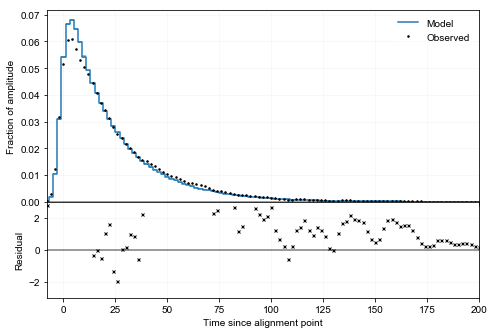

chi2 = 24.561852


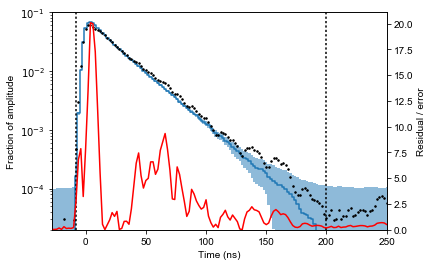

In [113]:
plot_model(**p)

In [114]:
optresult = minimize_it(['t3', 'fs'], [24, 0.2], **p)

gof=38.3193050473505, fs=0.2, t1=3.1, t3=24.0, tts=1.4
gof=32.36516057863114, fs=0.2, t1=3.1, t3=24.0, tts=1.4
gof=22.164771159381925, fs=0.2, t1=3.1, t3=25.0, tts=1.4
gof=7.255066962485152, fs=0.2, t1=3.1, t3=26.618034, tts=1.4
gof=132.6812029518941, fs=0.2, t1=3.1, t3=38.04639262203599, tts=1.4
gof=9.063496258343298, fs=0.2, t1=3.1, t3=26.618034, tts=1.4
gof=24.08900406290858, fs=0.2, t1=3.1, t3=30.983278429424598, tts=1.4
gof=8.53247513815723, fs=0.2, t1=3.1, t3=28.285408953729597, tts=1.4
gof=9.372462977191296, fs=0.2, t1=3.1, t3=27.565961316078223, tts=1.4
gof=14.908619963426714, fs=0.2, t1=3.1, t3=29.315903365882914, tts=1.4
gof=10.91832011601292, fs=0.2, t1=3.1, t3=28.67902278236215, tts=1.4
gof=9.768153140226516, fs=0.2, t1=3.1, t3=28.01060441736645, tts=1.4
gof=10.420689717412412, fs=0.2, t1=3.1, t3=28.435756053397057, tts=1.4
gof=8.185336222863857, fs=0.2, t1=3.1, t3=28.180442964193112, tts=1.4
gof=11.40005965342569, fs=0.2, t1=3.1, t3=28.115570413815917, tts=1.4
gof=12.15020

   direc: array([[ 0.        ,  1.        ],
       [-0.60487838, -0.00547913]])
     fun: 3.540775360476212
 message: 'Optimization terminated successfully.'
    nfev: 155
     nit: 4
  status: 0
 success: True
       x: array([ 25.72952094,   0.14701726])

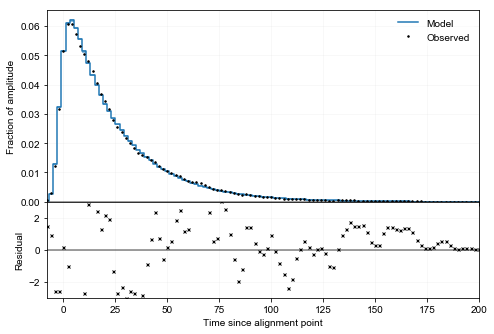

chi2 = 4.122560


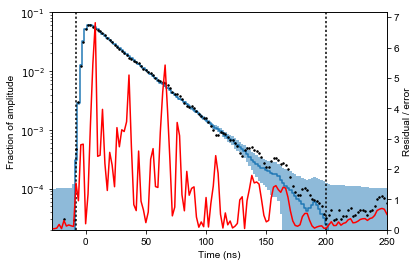

In [115]:
p['t3'], p['fs'] = optresult.x
plot_model(**p)

### Settings

In [75]:
cust_params = dict(
    s1_min = 30,
    s1_max = 100,
    dset = 'er',
    n_photons = int(2e5),
    spe_model = 'template'
)

### ER fit

Fit to the data.

In [42]:
from scipy import optimize
optresult = optimize.minimize(
    lambda x: gof(fs=x[0], t3=x[1], tts=x[2], **cust_params),
    [0.2, 25., 2.],
    options=dict(maxfev=1000),
    method='Powell',
)
print('Done')

gof=2.4997623145083065, fs=0.2, t1=3.1, t3=25.0, tts=2.0
gof=2.8085591288082314, fs=0.2, t1=3.1, t3=25.0, tts=2.0
gof=inf, fs=1.2, t1=3.1, t3=25.0, tts=2.0
gof=inf, fs=-1.418034, t1=3.1, t3=25.0, tts=2.0
gof=2.0262086450805805, fs=0.2, t1=3.1, t3=25.0, tts=2.0
gof=inf, fs=-0.418033974844, t1=3.1, t3=25.0, tts=2.0


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


gof=136.68227869772497, fs=0.581966, t1=3.1, t3=25.0, tts=2.0
gof=inf, fs=-0.036067965235263316, t1=3.1, t3=25.0, tts=2.0
gof=33.37384909340903, fs=0.34589802515600004, t1=3.1, t3=25.0, tts=2.0
gof=21.763532034405976, fs=0.08874044372580824, t1=3.1, t3=25.0, tts=2.0
gof=2.1032463302942763, fs=0.20251992867367422, t1=3.1, t3=25.0, tts=2.0
gof=2.055508969309565, fs=0.19289724217162854, t1=3.1, t3=25.0, tts=2.0
gof=2.5241690689259153, fs=0.19728698800332828, t1=3.1, t3=25.0, tts=2.0
gof=2.008751534640983, fs=0.1989637216596793, t1=3.1, t3=25.0, tts=2.0
gof=2.3555131030442373, fs=0.19832326641189751, t1=3.1, t3=25.0, tts=2.0
gof=2.3659906853705506, fs=0.19935954475221823, t1=3.1, t3=25.0, tts=2.0
gof=2.1947841561277275, fs=0.19871908953050507, t1=3.1, t3=25.0, tts=2.0
gof=2.371372663433902, fs=0.19911491262304404, t1=3.1, t3=25.0, tts=2.0
gof=2.145329064029561, fs=0.19887028050382713, t1=3.1, t3=25.0, tts=2.0
gof=2.129669532960392, fs=0.19902147146719187, t1=3.1, t3=25.0, tts=2.0
gof=2.182

In [43]:
fit = optresult.x
print(optresult)
print(fit)
ydata, _ = real_s1_wv(**cust_params)
minus, base, plus = s1_models_error(fs=fit[0], t3=fit[1], tts = fit[2], shifts = dict(tts=0.5, aft=0.24),
                                    mode='std', **cust_params)


   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 1.5527670989138798
 message: 'Optimization terminated successfully.'
    nfev: 107
     nit: 2
  status: 0
 success: True
       x: array([  0.1929466 ,  25.84936213,   1.67376208])
[  0.1929466   25.84936213   1.67376208]


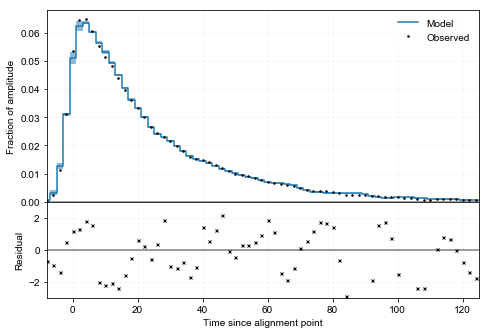

chi2 = 3.398243


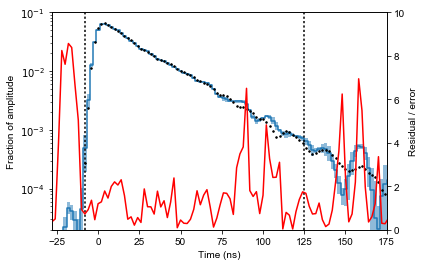

In [44]:
comparison_plot(ydata, minus, base, plus, **cust_params)
plt.show()
comparison_plot_2(ydata, minus, base, plus, **cust_params)
plt.ylim(0, 10)
plt.show()

### Single e pulse model

In [72]:
s1_waveforms, time_matrix, t_shift = simulate_s1_pulse(
    fs=fit[0], t3=fit[1], tts = fit[2], shifts = dict(tts=0.5, aft=0.24), 
    spe_model = 'template', s1_max = 5, s1_min = 2,
    #**cust_params
)

(-10, 100)

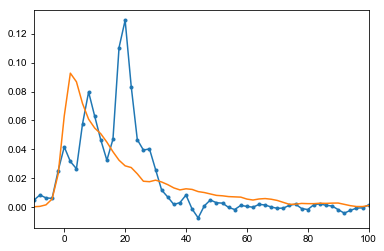

In [73]:
i = 0
plt.plot( time_matrix[:, i], s1_waveforms[:, i] / sum(s1_waveforms[:, i]), marker = '.')
plt.plot(spe_ts, average_pulse(time_matrix, s1_waveforms))
plt.xlim(-10, 100)

### Repeat and take median?

In [ ]:
iterations = 20
gofs_1 = [gof_repeat(1,fs=fit[0], t3=fit[1], tts = fit[2], **cust_params) for _ in range(iterations)]
gofs_2 = [gof_repeat(2,fs=fit[0], t3=fit[1], tts = fit[2], **cust_params) for _ in range(iterations)]
# gofs_3 = [gof_repeat(3,fs=fit[0], t3=fit[1], tts = fit[2], **cust_params) for _ in range(iterations)]
# gofs_4 = [gof_repeat(4,fs=fit[0], t3=fit[1], tts = fit[2], **cust_params) for _ in range(iterations)]
gofs_5 = [gof_repeat(5,fs=fit[0], t3=fit[1], tts = fit[2], **cust_params) for _ in range(iterations)]

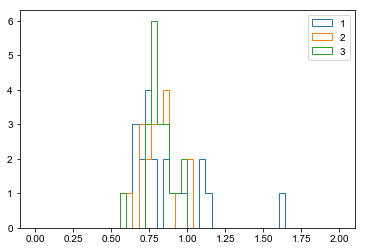

In [211]:
for i, gofs in enumerate([gofs_1, gofs_2, gofs_5]):
    plt.hist(gofs, bins=50, range=(0, 2), histtype='step', label='%d' % (i+1))
plt.legend()
plt.show()

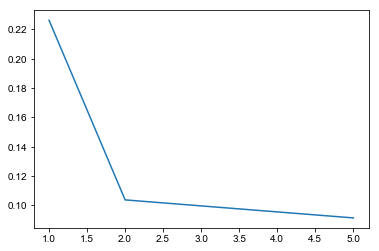

In [212]:
plt.plot([1, 2, 5], [np.std(gofs) for gofs in [gofs_1, gofs_2, gofs_5]])

### Repeat and take median

Here we repeat the gofs a couple of times, take the median, and then mimimize that. Ain't I clever? Except it totally maskes that I don't know where this comes from exactly...

By the way, we also take the previous fit as starting values. 

In [215]:
repeat = 3

In [ ]:
optimize.show_optionstions(solver='minimize', method='Powell')

In [216]:
optresult = optimize.minimize(
    lambda x: gof_repeat(repeat, fs=x[0], t3=x[1], tts=x[2], **cust_params),
    fit,
    options=dict(maxfev=1000
                 # maxiter
                 # disp (bool)
                 # direc (initial direction vectors)
                ),
    method='Powell',
)
print('Done')

gof=0.9249355158584385, fs=0.18572450652813277, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=0.7061973967899041, fs=0.18572450652813277, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=inf, fs=1.1857245065281328, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=inf, fs=-1.4323094934718672, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=0.737448493529934, fs=0.18572450652813277, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=inf, fs=-0.43230946831586725, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


gof=62.71456408422516, fs=0.5676905065281328, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=inf, fs=-0.050343458707130556, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=15.332419586364585, fs=0.3316225316841328, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=17.647143939890995, fs=0.06891051984956083, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=1.2559706509179516, fs=0.2049944499252993, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=1.6466491940846475, fs=0.1720620149726873, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=0.66960896783878, fs=0.19061841622170342, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=0.70036661584787, fs=0.1905694771147677, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=0.7464185920010472, fs=0.19610957231133114, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=0.9203722980653857, fs=0.19271585114863415, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=0.8177940

[  0.19382575  25.35017687   1.16652153]


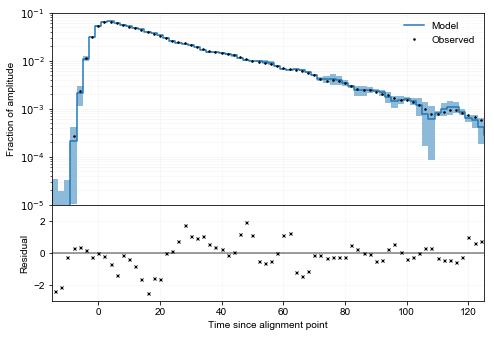

chi2 = 0.759650


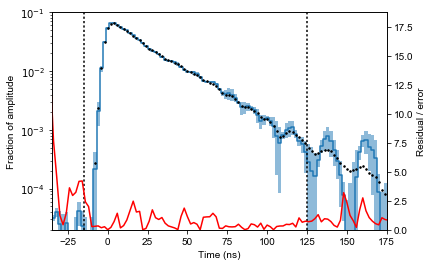

In [226]:
fit = optresult.x
print(fit)
ydata, _ = real_s1_wv(**cust_params)
minus, base, plus = s1_models_error(fs=fit[0], t3=fit[1], tts = fit[2], **cust_params)
comparison_plot(ydata, minus, base, plus, log=True, **cust_params)
plt.savefig('plots/ER_fit_log.png', bbox_inches='tight', dpi = 200)
plt.show()
comparison_plot_2(ydata, minus, base, plus, **cust_params)
plt.show()

### NR

In [129]:
cust_params['dset'] = 'nr'

In [125]:
from scipy import optimize
optresult = optimize.minimize(
    lambda x: gof(fs=x[0], t3=x[1], tts=x[2], **cust_params),
    [0.2, 25., 2.],
    options=dict(maxfev=1000),
    method='Powell',
)
print('Done')

gof=48.42871409166768, fs=0.2, t1=3.1, t3=25.0, tts=2.0
gof=54.41272114815102, fs=0.2, t1=3.1, t3=25.0, tts=2.0
gof=inf, fs=1.2, t1=3.1, t3=25.0, tts=2.0
gof=inf, fs=-1.418034, t1=3.1, t3=25.0, tts=2.0
gof=60.32590769295302, fs=0.2, t1=3.1, t3=25.0, tts=2.0
gof=inf, fs=-0.418033974844, t1=3.1, t3=25.0, tts=2.0


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


gof=180.0993408503418, fs=0.581966, t1=3.1, t3=25.0, tts=2.0
gof=inf, fs=-0.036067965235263316, t1=3.1, t3=25.0, tts=2.0
gof=22.17964478516514, fs=0.34589802515600004, t1=3.1, t3=25.0, tts=2.0
gof=21.57010772209669, fs=0.32661753939029664, t1=3.1, t3=25.0, tts=2.0
gof=19.918390144766672, fs=0.3294285667026415, t1=3.1, t3=25.0, tts=2.0
gof=20.35416056045645, fs=0.33583734514358354, t1=3.1, t3=25.0, tts=2.0
gof=19.85379657060987, fs=0.33187650216861436, t1=3.1, t3=25.0, tts=2.0
gof=21.454548945056327, fs=0.3331952672003005, t1=3.1, t3=25.0, tts=2.0
gof=20.248393059430537, fs=0.33187650216861436, t1=3.1, t3=25.0, tts=2.0
gof=29.331104199030815, fs=0.33187650216861436, t1=3.1, t3=26.0, tts=2.0
gof=18.69865740573422, fs=0.33187650216861436, t1=3.1, t3=23.381966, tts=2.0
gof=16.116933600014395, fs=0.33187650216861436, t1=3.1, t3=24.03667228757839, tts=2.0
gof=17.158755871077755, fs=0.33187650216861436, t1=3.1, t3=24.03667228757839, tts=2.0
gof=23.319903346551758, fs=0.33187650216861436, t1=3

[  0.31477283  23.55572853   2.6641913 ]


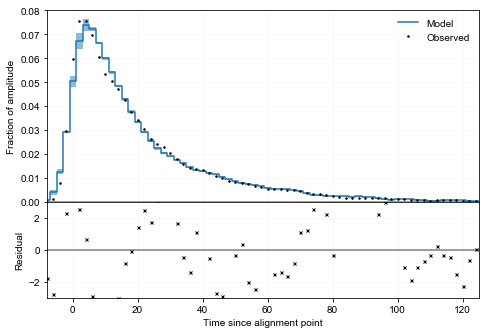

chi2 = 13.255704


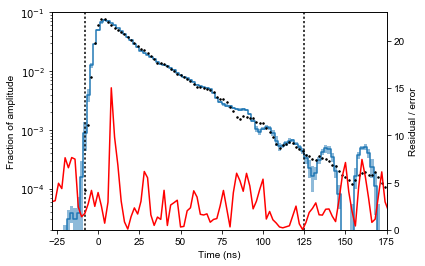

In [135]:
fit = optresult.x
print(fit)
ydata, _ = real_s1_wv(**cust_params)
minus, base, plus = s1_models_error(fs=fit[0], t3=fit[1], tts = fit[2], **cust_params)
comparison_plot(ydata, minus, base, plus, log=False, **cust_params)
plt.savefig('plots/NR_fit.png', bbox_inches='tight', dpi = 200)
plt.show()
comparison_plot_2(ydata, minus, base, plus, **cust_params)
plt.show()

In [133]:
repeat = 3

In [134]:
from scipy import optimize
optresult = optimize.minimize(
    lambda x: gof_repeat(repeat, fs=x[0], t3=x[1], tts=x[2], **cust_params),
    fit,
    options=dict(maxfev=1000),
    method='Powell',
)
print('Done')

gof=14.994264418508006, fs=0.3098712240156816, t1=3.1, t3=23.306900768108992, tts=2.2530002020175055
gof=13.776343519240188, fs=0.3098712240156816, t1=3.1, t3=23.306900768108992, tts=2.2530002020175055
gof=inf, fs=1.3098712240156816, t1=3.1, t3=23.306900768108992, tts=2.2530002020175055
gof=inf, fs=-1.3081627759843184, t1=3.1, t3=23.306900768108992, tts=2.2530002020175055
gof=13.404674408430514, fs=0.3098712240156816, t1=3.1, t3=23.306900768108992, tts=2.2530002020175055
gof=inf, fs=-0.3081627508283184, t1=3.1, t3=23.306900768108992, tts=2.2530002020175055


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


gof=245.5462990118858, fs=0.6918372240156816, t1=3.1, t3=23.306900768108992, tts=2.2530002020175055
gof=109.14402832068582, fs=0.0738032587804183, t1=3.1, t3=23.306900768108992, tts=2.2530002020175055
gof=12.886184124969992, fs=0.31551514643297063, t1=3.1, t3=23.306900768108992, tts=2.2530002020175055
gof=20.51390628606278, fs=0.3480868032299312, t1=3.1, t3=23.306900768108992, tts=2.2530002020175055
gof=13.246560810050875, fs=0.31807694990991076, t1=3.1, t3=23.306900768108992, tts=2.2530002020175055
gof=12.307929078721017, fs=0.31431405764109993, t1=3.1, t3=23.306900768108992, tts=2.2530002020175055
gof=14.52493145509022, fs=0.3126170462525334, t1=3.1, t3=23.306900768108992, tts=2.2530002020175055
gof=12.36810475191699, fs=0.31366585698905475, t1=3.1, t3=23.306900768108992, tts=2.2530002020175055
gof=13.711755087638462, fs=0.31413943099230596, t1=3.1, t3=23.306900768108992, tts=2.2530002020175055
gof=12.078659293629602, fs=0.3147728327225756, t1=3.1, t3=23.306900768108992, tts=2.253000

[  0.31477283  23.55572853   2.6641913 ]


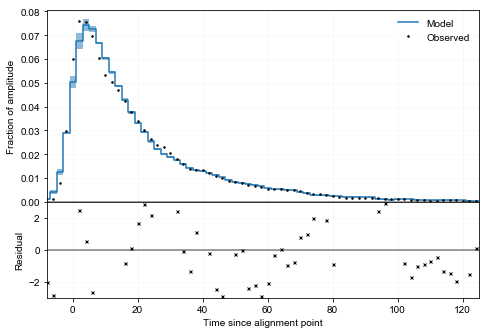

chi2 = 15.484423


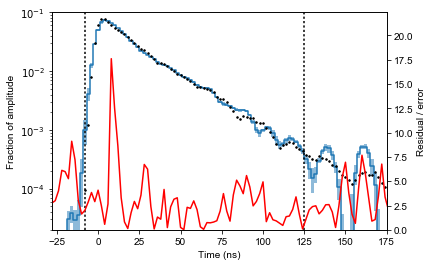

In [136]:
fit = optresult.x
print(fit)
ydata, _ = real_s1_wv(**cust_params)
minus, base, plus = s1_models_error(fs=fit[0], t3=fit[1], tts = fit[2], **cust_params)
comparison_plot(ydata, minus, base, plus, log=False, **cust_params)
# plt.savefig('plots/NR_fit.png', bbox_inches='tight', dpi = 200)
plt.show()
comparison_plot_2(ydata, minus, base, plus, **cust_params)
plt.show()

### Fit... Something else!

In [148]:
cust_params

{'dset': 'nr', 'n_photons': 200000, 's1_max': 100, 's1_min': 30}

In [149]:
from scipy import optimize
optresult = optimize.minimize(
    lambda x: gof(fs=x[0], t3=x[1], t1 = x[2], tts=1.5, **cust_params),
    [0.3, 24., 3.],
    options=dict(maxfev=1000),
    method='Powell',
)
print('Done')

gof=10.727519897272824, fs=0.3, t1=3.0, t3=24.0, tts=1.5
gof=6.803759597680593, fs=0.3, t1=3.0, t3=24.0, tts=1.5
gof=inf, fs=1.3, t1=3.0, t3=24.0, tts=1.5
gof=inf, fs=-1.318034, t1=3.0, t3=24.0, tts=1.5
gof=6.741023952160279, fs=0.3, t1=3.0, t3=24.0, tts=1.5
gof=inf, fs=-0.31803397484400003, t1=3.0, t3=24.0, tts=1.5


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


gof=121.61969096745464, fs=0.6819660000000001, t1=3.0, t3=24.0, tts=1.5
gof=96.42710123338009, fs=0.06393203476473666, t1=3.0, t3=24.0, tts=1.5
gof=15.727962383847421, fs=0.3544433587093264, t1=3.0, t3=24.0, tts=1.5
gof=7.118512220487114, fs=0.2832255265233266, t1=3.0, t3=24.0, tts=1.5
gof=6.72270646016299, fs=0.2958848733385419, t1=3.0, t3=24.0, tts=1.5
gof=7.809921340351921, fs=0.29689717527035736, t1=3.0, t3=24.0, tts=1.5
gof=7.219765244599201, fs=0.2910494332729214, t1=3.0, t3=24.0, tts=1.5
gof=7.695153626609413, fs=0.2940378996384371, t1=3.0, t3=24.0, tts=1.5
gof=6.577240414787293, fs=0.2951793921822077, t1=3.0, t3=24.0, tts=1.5
gof=7.72183175586082, fs=0.2947433808412338, t1=3.0, t3=24.0, tts=1.5
gof=8.325296877003147, fs=0.29544886199756804, t1=3.0, t3=24.0, tts=1.5
gof=8.149634395567913, fs=0.29501285067434124, t1=3.0, t3=24.0, tts=1.5
gof=7.125136471249634, fs=0.2952823204897016, t1=3.0, t3=24.0, tts=1.5
gof=6.437531687833373, fs=0.29511577898861396, t1=3.0, t3=24.0, tts=1.5
g

[  0.28746834  21.86432122   0.80930424]


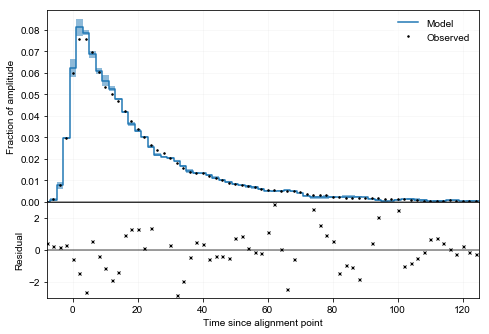

chi2 = 3.769584


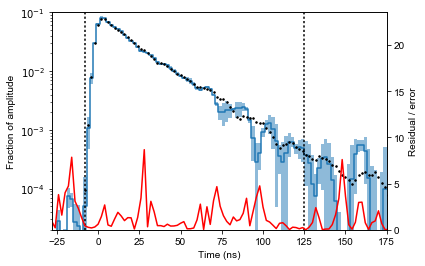

In [150]:
fit = optresult.x
print(fit)
ydata, _ = real_s1_wv(**cust_params)
minus, base, plus = s1_models_error(fs=fit[0], t3=fit[1], t1 = fit[2], tts=1.5, **cust_params)
comparison_plot(ydata, minus, base, plus, log=False, **cust_params)
# plt.savefig('plots/NR_fit.png', bbox_inches='tight', dpi = 200)
plt.show()
comparison_plot_2(ydata, minus, base, plus, **cust_params)
plt.show()

In [220]:
def get_ratio(fs):
    return fs/(1-fs)

In [221]:
get_ratio(0.19382575)

0.24042661992739162

In [223]:
get_ratio(0.28152421)

0.39183534632391714

### Uncertainty estimate

In [42]:
def gof_v_parameter(parameter, variation_range, num, **params):
    params_to_try = np.linspace(*variation_range, num=num)
    gofs = []
    for param_value in params_to_try:
        params[parameter] = param_value
        gofs.append(gof(**params))
    return params_to_try, np.array(gofs)

from tqdm import tqdm
def gof_v_2_paramters(repeat, parameter1, parameter2, variation_range1, variation_range2, num1, num2, **params):
    import time
    start = time.time()
    params_to_try1 = np.linspace(*variation_range1, num=num1)
    params_to_try2 = np.linspace(*variation_range2, num=num2)
    ding = []
    for par1 in tqdm(params_to_try1):
        for par2 in params_to_try2:
            params[parameter1] = par1
            params[parameter2] = par2
            gof_value = gof_repeat(repeat, **params)
            ding.append([par1, par2, gof_value])
    stop = time.time()
    print('Computation took %d seconds (%.1f s/it)' % ((stop - start), (stop - start) / len(ding)))
    return np.array(ding)

In [172]:
nx = 40
ny = 40
ding = gof_v_2_paramters('fs', 't3', (0.18, 0.20), (24.5, 25.5), nx, ny, tts=fit[2], verbose=False)

100%|██████████| 40/40 [23:29<00:00, 34.72s/it]

Computation took 1409 seconds (0.9 s/it)


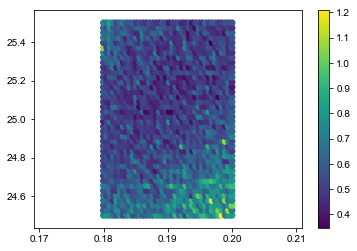

In [173]:
plt.scatter(ding[:,0], ding[:,1], c=ding[:, 2])
plt.colorbar()

In [81]:
chi2 = scipy.stats.chi2

In [101]:
df = int((default_params['t_max'] - default_params['t_min']) * 0.5)

In [125]:
chi2.cdf(3 * 3, df=3)

0.97070911346511179

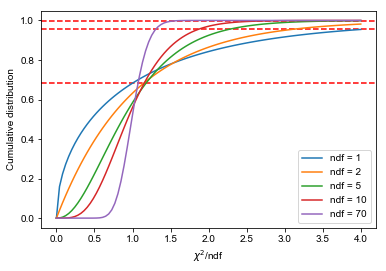

In [144]:
x_plot = np.linspace(0, 4, 100)

for cl in (0.6827, 0.9545, 0.9973):
    plt.axhline(cl, ls='--', color='red')
    
for _df in [1, 2, 5, 10, 70]:
    plt.plot(x_plot, [chi2.cdf(_x * _df, df=_df) for _x in x_plot], label='ndf = %d' % _df)
plt.legend()
plt.xlabel('$\chi^2$/ndf')
plt.ylabel('Cumulative distribution')



In [188]:
x_plot = np.linspace(1, 2, 400)
_df = 70
cl = 0.9545 # 2 sigma


value = x_plot[np.argmin(np.abs(np.array([[chi2.cdf(_x * _df, df=_df) for _x in x_plot]]) - cl))]
print(value)

1.30325814536


In [158]:
chi2.cdf(0.34474512411 * 70, df=70, loc=0, scale=0.34474512411)

0.52248119042994245

In [159]:
chi2.cdf(70, df=70, loc=0, scale=1)

0.52248119042994245

0.346963369167


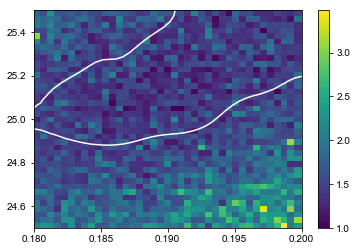

In [187]:
x = np.reshape(ding[:, 0], (nx, ny))
y = np.reshape(ding[:, 1], (nx, ny))
z = np.reshape(ding[:, 2], (nx, ny)) 
print(np.min(z))
z = z / np.min(z)


int_fac = 1
sigma = 3

xn = scipy.ndimage.zoom(x, int_fac)
yn = scipy.ndimage.zoom(y, int_fac)
zn = scipy.ndimage.zoom(z, int_fac)
zn = scipy.ndimage.gaussian_filter(zn, sigma)


levels = [1.5]
plt.contour(xn, yn, zn, levels, colors='white')
plt.pcolormesh(x, y, z)

plt.colorbar()

In [ ]:
edge_x = ding[:, 0]
edge_y = 
plt.figure()
ax = plt.gca()
pc = ax.pcolormesh(edge_x, edge_y, 1000* (h_fg - h_bg).T,  cmap='RdBu', vmin = -3e-1, vmax = 3e-1)

In [157]:
fss, gofs = gof_v_parameter('fs', (0.14, 0.24), 20, fs=fit[0], t3=fit[1], tts=fit[2], error_pct = 1e-2, error_offset = 1e-4)

gof=0.8223248960610716, fs=0.14, t1=3.1, t3=25.314533292606356, tts=1.2653254314891729
gof=0.7518969908565659, fs=0.14526315789473684, t1=3.1, t3=25.314533292606356, tts=1.2653254314891729
gof=0.5375879783198912, fs=0.1505263157894737, t1=3.1, t3=25.314533292606356, tts=1.2653254314891729
gof=0.563174577752749, fs=0.15578947368421053, t1=3.1, t3=25.314533292606356, tts=1.2653254314891729
gof=0.43184031947407575, fs=0.1610526315789474, t1=3.1, t3=25.314533292606356, tts=1.2653254314891729
gof=0.30005747084716083, fs=0.16631578947368422, t1=3.1, t3=25.314533292606356, tts=1.2653254314891729
gof=0.2460460642009813, fs=0.17157894736842105, t1=3.1, t3=25.314533292606356, tts=1.2653254314891729
gof=0.20121751674928934, fs=0.1768421052631579, t1=3.1, t3=25.314533292606356, tts=1.2653254314891729
gof=0.1538217910931106, fs=0.18210526315789474, t1=3.1, t3=25.314533292606356, tts=1.2653254314891729
gof=0.16741921838243617, fs=0.18736842105263157, t1=3.1, t3=25.314533292606356, tts=1.265325431489

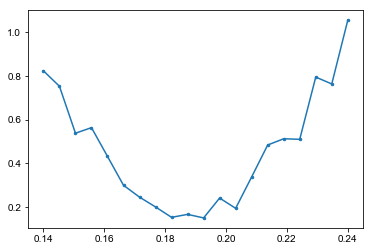

In [158]:
plt.plot(fss, gofs, marker='.', markersize=5)

In [135]:
optresult_nr = optimize.minimize(
    lambda x: gof(fs=x[0], t3=x[1], tts=x[2], dset = 'nr', error_pct = 1e-2, error_offset = 1e-4),
    [0.2, 24, 3],
    bounds=[[.01, 1], [20, 30], [.1, 5]],
    options=dict(maxfev=1000),
    method='Powell',
)

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


gof=5.404165191595393, fs=0.2, t1=3.1, t3=24.0, tts=3.0
gof=4.901261384945134, fs=0.2, t1=3.1, t3=24.0, tts=3.0
gof=inf, fs=1.2, t1=3.1, t3=24.0, tts=3.0
gof=inf, fs=-1.418034, t1=3.1, t3=24.0, tts=3.0
gof=5.100265985289571, fs=0.2, t1=3.1, t3=24.0, tts=3.0
gof=inf, fs=-0.418033974844, t1=3.1, t3=24.0, tts=3.0


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


gof=20.667156369428504, fs=0.581966, t1=3.1, t3=24.0, tts=3.0
gof=inf, fs=-0.036067965235263316, t1=3.1, t3=24.0, tts=3.0
gof=1.5463955247032297, fs=0.34589802515600004, t1=3.1, t3=24.0, tts=3.0
gof=1.6943681213633022, fs=0.31710503490593894, t1=3.1, t3=24.0, tts=3.0
gof=1.9966769477411725, fs=0.34735700541756004, t1=3.1, t3=24.0, tts=3.0
gof=1.5504039444214925, fs=0.3317492787233509, t1=3.1, t3=24.0, tts=3.0
gof=1.5494328170231437, fs=0.3404936850761068, t1=3.1, t3=24.0, tts=3.0
gof=1.665766759993852, fs=0.34383375099304353, t1=3.1, t3=24.0, tts=3.0
gof=1.7171111053948453, fs=0.34589802515600004, t1=3.1, t3=24.0, tts=3.0
gof=2.0321923608937515, fs=0.34589802515600004, t1=3.1, t3=25.0, tts=3.0
gof=1.9879370439724404, fs=0.34589802515600004, t1=3.1, t3=22.381966, tts=3.0
gof=1.6604266196241677, fs=0.34589802515600004, t1=3.1, t3=24.0, tts=3.0
gof=1.7296053834654685, fs=0.34589802515600004, t1=3.1, t3=23.381966025156, tts=3.0
gof=1.7493126792831641, fs=0.34589802515600004, t1=3.1, t3=24.

[  0.28152421  22.90795037   1.47498146]


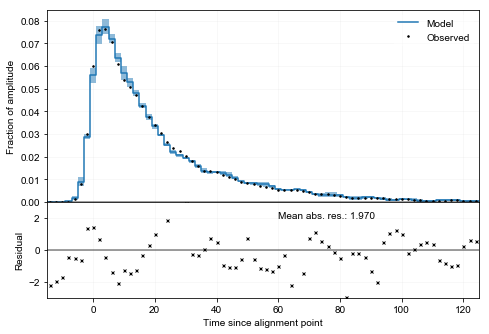

chi2 = 0.700723


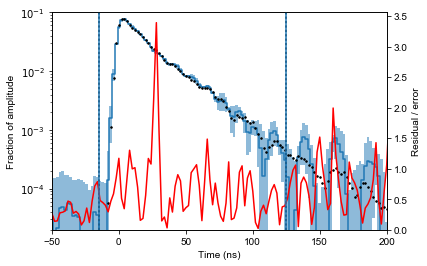

In [137]:
fit = optresult_nr.x
print(fit)
ydata, _ = real_s1_wv(dset='nr')
minus, base, plus = s1_models_error(fs=fit[0], t3=fit[1], tts=fit[2], dset='nr', error_pct = 1e-2, error_offset = 1e-4)
comparison_plot(ydata, minus, base, plus, error_pct = 1e-2, error_offset = 1e-4)
plt.show()
comparison_plot_2(ydata, minus, base, plus, error_pct = 1e-2, error_offset = 1e-4)
for _l in (-15, 125):
    plt.axvline(_l)
plt.xlim(-50, 200)
plt.show()

In [ ]:
plt.hist(xams_data['er']['s1'], bins=100, histtype='step', range=(50,100))
plt.hist(xams_data['nr']['s1'], bins=100, histtype='step', range=(50,100))
plt.show()

## Fit four parameters

### ER

In [4]:
from scipy import optimize
optresult = optimize.minimize(
    lambda x: gof(fs=x[0], t1=x[1], t3=x[2], tts=x[3], s1_min=30, s1_max = 100, dset='er'),
    [0.2, 3.1, 24, 3],
    bounds=[[.01, 1], [.1, 5], [20, 30], [.1, 5]],
    options=dict(maxfev=1000),
    method='Powell',
)

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


NameError: name 'gof' is not defined

In [ ]:
# fit = optresult.x
# ydata, _ = real_s1_wv()
# minus, base, plus = s1_models_error(fs=fit[0], t1=fit[1], t3=fit[2], tts=fit[3])
# comparison_plot(ydata, minus, base, plus)

In [ ]:
fit = optresult.x
print(fit)
ydata, _ = real_s1_wv()
minus, base, plus = s1_models_error(fs=fit[0], t1=fit[1], t3=fit[2], tts=fit[3], s1_min=30, s1_max = 100)
comparison_plot(ydata, minus, base, plus)
plt.show()
comparison_plot_2(ydata, minus, base, plus)
for _l in (-20, 100):
    plt.axvline(_l)
plt.xlim(-50, 200)
plt.show()

The fit is pushing the singlet livetime to very low values... There is some degeneracy here, and also some mis-modeling, it seems. The sample at 0 is always under-estimated. Why? Maybe because the tts is actually quite low but modeled here as large. The effects may not be symmetric: there are many things causing a delay, but not a negative delay. 

### NR

In [5]:
from scipy import optimize
optresult = optimize.minimize(
    lambda x: gof(fs=x[0], t1=x[1], t3=x[2], tts=x[3], s1_min=30, s1_max = 100, dst='nr'),
    [0.2, 3.1, 24, 3],
    bounds=[[.01, 1], [.1, 5], [20, 30], [.1, 5]],
    options=dict(maxfev=1000),
    method='Powell',
)

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


NameError: name 'gof' is not defined

In [ ]:
fit = optresult.x
print(fit)
ydata, _ = real_s1_wv(s1_min=30, s1_max = 100, dset='nr')
minus, base, plus = s1_models_error(fs=fit[0], t1=fit[1], t3=fit[2], tts=fit[3], s1_min=30, s1_max = 100, dset='nr')
comparison_plot(ydata, minus, base, plus)
plt.show()
comparison_plot_2(ydata, minus, base, plus)
for _l in (-20, 100):
    plt.axvline(_l)
plt.xlim(-50, 200)
plt.show()


## Zero field

In [60]:
cust_settings = dict(
    s1_min = 50, s1_max = 100, dset = 'er_0', fs = 0.2, t3=25.2, tts = 1.5
)

ydata, _ = real_s1_wv(**cust_settings)
minus, base, plus = s1_models_error(**cust_settings)

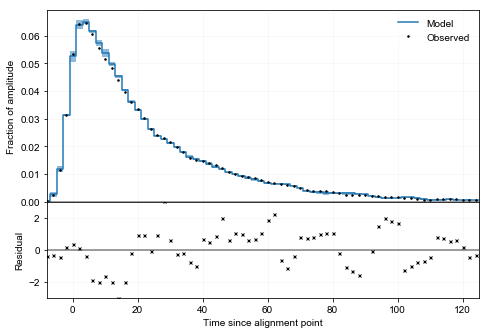

In [59]:
comparison_plot(ydata, minus, base, plus)

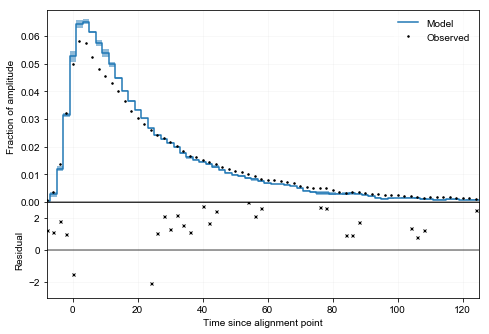

In [61]:
comparison_plot(ydata, minus, base, plus)

### Fit 

In [63]:
cust_settings = dict(
    s1_min = 50, s1_max = 100, dset = 'er_0', tts = 1.5
)

In [64]:
from scipy import optimize
optresult = optimize.minimize(
    lambda x: gof(fs = x[0], t3=x[1], **cust_settings),
    [0.2, 25],
    bounds=[[.01, 1], [.1, 5], [20, 30], [.1, 5]],
    options=dict(maxfev=1000),
    method='Powell',
)

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


gof=20.65879942375894, fs=0.2, t1=3.1, t3=25.0, tts=1.5
gof=18.405236394217813, fs=0.2, t1=3.1, t3=25.0, tts=1.5
gof=inf, fs=1.2, t1=3.1, t3=25.0, tts=1.5
gof=inf, fs=-1.418034, t1=3.1, t3=25.0, tts=1.5
gof=18.801461007846505, fs=0.2, t1=3.1, t3=25.0, tts=1.5
gof=inf, fs=-0.418033974844, t1=3.1, t3=25.0, tts=1.5


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


gof=96.99495311421744, fs=0.581966, t1=3.1, t3=25.0, tts=1.5
gof=inf, fs=-0.036067965235263316, t1=3.1, t3=25.0, tts=1.5
gof=37.846291331062844, fs=0.34589802515600004, t1=3.1, t3=25.0, tts=1.5
gof=15.532674882474515, fs=0.06523796393133371, t1=3.1, t3=25.0, tts=1.5
gof=15.291333310389813, fs=0.10059162045501235, t1=3.1, t3=25.0, tts=1.5
gof=15.824387652332753, fs=0.09383108331872093, t1=3.1, t3=25.0, tts=1.5
gof=14.2843903380813, fs=0.1385622415562931, t1=3.1, t3=25.0, tts=1.5
gof=15.867476293179118, fs=0.16202937639800208, t1=3.1, t3=25.0, tts=1.5
gof=15.979053339310111, fs=0.12405875529672131, t1=3.1, t3=25.0, tts=1.5
gof=15.463435094191608, fs=0.14752588918324133, t1=3.1, t3=25.0, tts=1.5
gof=15.478319179464336, fs=0.1330224029236695, t1=3.1, t3=25.0, tts=1.5
gof=15.00678196843482, fs=0.14198605018576801, t1=3.1, t3=25.0, tts=1.5
gof=15.391171707822368, fs=0.1364462115531444, t1=3.1, t3=25.0, tts=1.5
gof=13.06877929169023, fs=0.1398700200432591, t1=3.1, t3=25.0, tts=1.5
gof=15.0330

In [67]:
fit = optresult.x

In [70]:
cust_settings['tts'] = 1.

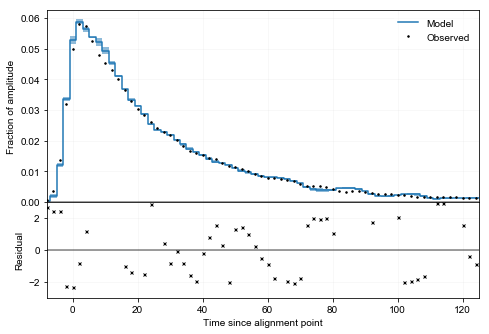

In [71]:
ydata, _ = real_s1_wv(**cust_settings)
minus, base, plus = s1_models_error(fs = fit[0], t3=fit[1], **cust_settings)
comparison_plot(ydata, minus, base, plus)
